In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
import random
import transformers


import os
import sys
sys.path.append('..')

from relations import estimate
from util import model_utils
from dsets.counterfact import CounterFactDataset
from util import nethook
from operator import itemgetter


In [4]:
MODEL_NAME = "EleutherAI/gpt-j-6B"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float32)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

print(f"{MODEL_NAME} ==> device: {model.device}, memory: {model.get_memory_footprint()}")

EleutherAI/gpt-j-6B ==> device: cuda:0, memory: 24320971760


In [5]:
counterfact = CounterFactDataset("../data/")

Loaded dataset with 21919 elements


In [6]:
###################################################################################
final_layer_norm_name = "transformer.ln_f"
decoder_name = "lm_head"
###################################################################################

In [9]:
final_layer_norm = nethook.get_module(model, final_layer_norm_name)
decoder = nethook.get_module(model, decoder_name)

def get_vocab_representation(h, perform_layer_norm = True, return_top_k = 5):
    z = h.clone()
    if(perform_layer_norm == True):
        z = final_layer_norm(z)
    logits = decoder(z)
    token_ids = logits.topk(dim=-1, k=return_top_k).indices.squeeze().tolist()
    return [
        tokenizer.decode(t) for t in token_ids
    ]

In [10]:
cut_off = 50 # minimum number of correct predictions

###########################################################################
relation_dct = {
    'P17'   : {'relation': '{} is located in the country of', 'correct_predict': None, 'cached_JB': None},
    'P641'  : {'relation': '{} plays the sport of', 'correct_predict': None, 'cached_JB': None},
    'P103'  : {'relation': 'The mother tongue of {} is', 'correct_predict': None, 'cached_JB': None},
    'P176'  : {'relation': '{} is produced by', 'correct_predict': None, 'cached_JB': None},
    'P140'  : {'relation': 'The official religion of {} is', 'correct_predict': None, 'cached_JB': None},
    'P1303' : {'relation': '{} plays the instrument', 'correct_predict': None, 'cached_JB': None},
    'P190'  : {'relation': 'What is the twin city of {}? It is', 'correct_predict': None, 'cached_JB': None},
    'P740'  : {'relation': '{} was founded in', 'correct_predict': None, 'cached_JB': None},
    'P178'  : {'relation': '{} was developed by', 'correct_predict': None, 'cached_JB': None},
    'P495'  : {'relation': '{}, that originated in the country of', 'correct_predict': None, 'cached_JB': None},
    'P127'  : {'relation': '{} is owned by', 'correct_predict': None, 'cached_JB': None},
    'P413'  : {'relation': '{} plays in the position of', 'correct_predict': None, 'cached_JB': None},
    'P39'   : {'relation': '{}, who holds the position of', 'correct_predict': None, 'cached_JB': None},
    'P159'  : {'relation': 'The headquarter of {} is located in', 'correct_predict': None, 'cached_JB': None},
    'P20'   : {'relation': '{} died in the city of', 'correct_predict': None, 'cached_JB': None},
    'P136'  : {'relation': 'What does {} play? They play', 'correct_predict': None, 'cached_JB': None},
    'P106'  : {'relation': 'The profession of {} is', 'correct_predict': None, 'cached_JB': None},
    'P30'   : {'relation': '{} is located in the continent of', 'correct_predict': None, 'cached_JB': None},
    'P937'  : {'relation': '{} worked in the city of', 'correct_predict': None, 'cached_JB': None},
    'P449'  : {'relation': '{} was released on', 'correct_predict': None, 'cached_JB': None},
    'P27'   : {'relation': '{} is a citizen of', 'correct_predict': None, 'cached_JB': None},
    'P101'  : {'relation': '{} works in the field of', 'correct_predict': None, 'cached_JB': None},
    'P19'   : {'relation': '{} was born in', 'correct_predict': None, 'cached_JB': None},
    'P37'   : {'relation': 'In {}, an official language is', 'correct_predict': None, 'cached_JB': None},
    'P138'  : {'relation': '{}, named after', 'correct_predict': None, 'cached_JB': None},
    'P131'  : {'relation': '{} is located in', 'correct_predict': None, 'cached_JB': None},
    'P407'  : {'relation': '{} was written in', 'correct_predict': None, 'cached_JB': None},
    'P108'  : {'relation': '{}, who is employed by', 'correct_predict': None, 'cached_JB': None},
    'P36'   : {'relation': 'The capital of {} is', 'correct_predict': None, 'cached_JB': None},
}
###########################################################################

root_path = "gpt-j"

pop_track = []
for relation in relation_dct:
    path = f"{root_path}/{relation}"
    with open(f"{path}/correct_prediction_{relation}.json") as f:
        correct_predictions = json.load(f)
    if(len(correct_predictions) < cut_off):
    # if "performance" not in os.listdir(path):
        print("skipped ", relation)
        pop_track.append(relation)
    
for r in pop_track:
    relation_dct.pop(r)

skipped  P1303
skipped  P190
skipped  P740
skipped  P413
skipped  P39
skipped  P136
skipped  P449
skipped  P138
skipped  P131
skipped  P407
skipped  P108


## Calculating the Corner

In [11]:
from typing import Any, Sequence, TypeAlias, List
import matplotlib.pyplot as plt

Model: TypeAlias = transformers.GPT2LMHeadModel
Tokenizer: TypeAlias = transformers.PreTrainedTokenizerFast

def calculate_corner(
    model: Model, tokenizer: Tokenizer,
    target_words: List[str],

    learning_rate: float = 5e-2,
    weight_decay: float = 2e-2,
    num_steps: int = 100,
    target_logit_value: float = 50,

    plot_loss: bool = False
):
    target_tokenized = tokenizer(target_words, padding=True, return_tensors="pt").to(model.device)
    print(target_tokenized.input_ids.shape)

    tunable_weights = {}
    for n, p in model.named_parameters():
        if n.startswith(final_layer_norm_name) or n.startswith(decoder_name):
            tunable_weights[n] = p
            p.requires_grad = True
        else:
            p.requires_grad = False

    z = torch.FloatTensor(model.config.n_embd).uniform_(-1.001 , 1.001).to(model.dtype).to(model.device)
    print("initial representation: ", get_vocab_representation(z))
    z.requires_grad = True

    optimizer = torch.optim.Adam(
        [z],
        lr=learning_rate,
        weight_decay=weight_decay,
    )

    loss_track = []
    for iter in range(num_steps):
        logits = decoder(final_layer_norm(z))
        target_logits = torch.gather(logits, 0, target_tokenized.input_ids.reshape(len(target_words)))
        # print(target_logits)
        # loss = -target_logits.sum().square() #+ 1000 * entropy(target_logits) #+ logits.sum()

        optimal_logit_values = torch.zeros(target_logits.shape) + target_logit_value
        optimal_logit_values = optimal_logit_values.to(model.dtype).to(model.device)
        # loss = (optimal_logit_values - target_logits).square().mean() + logits.square().mean()
        loss = (optimal_logit_values - target_logits).square().mean() + logits.mean()
        # print((optimal_logit_values - target_logits).square().mean().item(), logits.mean().item())

        # optimal_logit_values = torch.zeros(model.config.vocab_size) - 1
        # for t in target_tokenized.input_ids:
        #     optimal_logit_values[t[0]] = 10
        # optimal_logit_values = optimal_logit_values.to(model.dtype).to(model.device)
        # print(torch.gather(optimal_logit_values, 0, target_tokenized.input_ids.reshape(len(target_words))))
        # loss = (optimal_logit_values - logits).mean().square()
        
        loss_track.append(loss.item())
        # print(loss.item(), logits.mean().item(), target_logits.sum().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for t in tunable_weights:
            tunable_weights[t].grad.zero_()
    
    for t in tunable_weights:
        tunable_weights[t].requires_trad = False
    z.requires_grad = False
    print("final representation: ", get_vocab_representation(z))

    if(plot_loss):
        plt.rcdefaults()
        plt.plot(loss_track)
        plt.xticks(range(0, len(loss_track), 10))
        plt.xlabel("Iteration")
        plt.ylabel("loss")

    return z


def calculate_corner_average(
    model: Model, tokenizer: Tokenizer,
    target_words: List[str],

    learning_rate: float = 5e-2,
    weight_decay: float = 2e-2,
    num_steps: int = 100,
    target_logit_value: float = 50,

    plot_loss: bool = False,

    num_corners: int = 5 # calculate 5 corners and return the average of them
):  
    corners = [calculate_corner(
        model, tokenizer,
        target_words,
        learning_rate, weight_decay, num_steps, target_logit_value,
        plot_loss 
    ) for _ in range(num_corners)]

    corner = torch.stack(corners)
    return corner.mean(dim = 0)

# corner = calculate_corner_average(
#     model, tokenizer, objects,
#     # plot_loss= True,
# )

## Test on a relation

In [14]:
#################################################
relation_id = "P17"
precision_at = 3
#################################################

correctly predicted:  404
unique objects:  95 [' Peru', ' Ireland', ' Taiwan', ' Qatar', ' Colombia']
torch.Size([95, 1])
initial representation:  ['Ven', 'die', ' Harbour', ' Sea', ' drunk']
final representation:  [' Nigeria', ' Bangladesh', ' Ukraine', ' Cyprus', ' Finland']
torch.Size([95, 1])
initial representation:  ['action', 'ier', 'ACTION', ' Policies', ' Details']
final representation:  [' Indonesia', ' Bangladesh', ' Cuba', ' Ukraine', ' Uganda']
torch.Size([95, 1])
initial representation:  ['of', 'EXT', 'OM', 'S', 'T']
final representation:  [' Nigeria', ' Venezuela', ' Kenya', ' Cuba', ' Indonesia']
torch.Size([95, 1])
initial representation:  ['@', ' PAN', ' ADA', ' TA', ' []']
final representation:  [' Ukraine', ' Malta', ' Belgium', ' Uganda', ' Malaysia']
torch.Size([95, 1])
initial representation:  ['ica', ' Bud', ' Bon', ' Ang', 'ican']
final representation:  [' Iceland', ' Bangladesh', ' Venezuela', ' Switzerland', ' Indonesia']


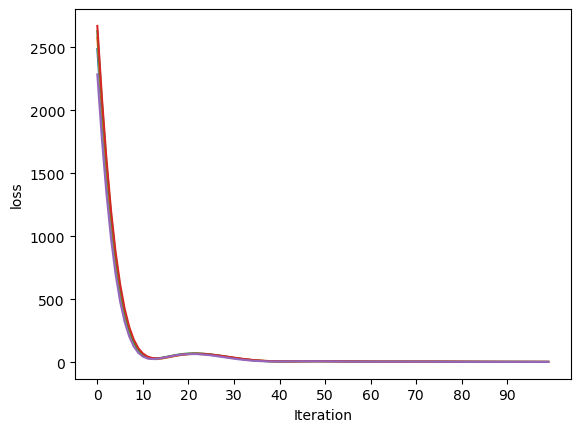

In [31]:
with open(f"{root_path}/{relation_id}/correct_prediction_{relation_id}.json") as f:
    correct_predictions = json.load(f)
print("correctly predicted: ", len(correct_predictions))

objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
objects = [" "+ o['target_true']['str'] for o in objects]
objects = list(set(objects))
print("unique objects: ", len(objects), objects[0:5])

corner = calculate_corner_average(
    model, tokenizer, objects,
    plot_loss= True,
)

In [32]:
model.config.n_layer

28

In [33]:
relation_identity = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = relation_dct[relation_id]['relation'],
    layer = 15,
    weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
    bias = corner
)

In [34]:
jb = np.load(f"gpt-j/jacobians_averaged/{relation_id}.npz", allow_pickle= True)

weight = torch.tensor(jb["JB"][0]["weight"])
bias = jb["JB"][0]["bias"]

relation_jacobian = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = relation_dct[relation_id]['relation'],
    layer = 15,
    weight = weight.to(model.dtype).to(model.device),
    bias = corner
)

In [35]:
# test_subjects = [
#     "Hugh Jackman",
#     "Michael Phelps",
#     "Agatha Christie",
#     "Barack Obama",
#     "Sherlock Holmes",
#     "Alan Turing",
#     "Bill Gates",
#     "Michelangelo",
#     "Michael Jackson"
# ]

# for sub in test_subjects:
#     print(f"{sub} >> ", relation_identity(sub, device= model.device))

# print("\n\n")

# for sub in test_subjects:
#     print(f"{sub} >> ", relation_jacobian(sub, device= model.device))

In [36]:
def P17__check_with_test_cases(relation_operator):

    test_cases = [
        ("The Great Wall", -1, "China"),
        ("Niagara Falls", -2, "Canada"),
        ("Valdemarsvik", -1, "Sweden"),
        ("Kyoto University", -2, "Japan"),
        ("Hattfjelldal", -1, "Norway"),
        ("Ginza", -1, "Japan"),
        ("Sydney Hospital", -2, "Australia"),
        ("Mahalangur Himal", -1, "Nepal"),
        ("Higashikagawa", -1, "Japan"),
        ("Trento", -1, "Italy"),
        ("Taj Mahal", -1, "India"),
        ("Hagia Sophia", -1, "Turkey"),
        ("Colosseum", -1, "Italy"),
        ("Mount Everest", -1, "Nepal"),
        ("Valencia", -1, "Spain"),
        ("Lake Baikal", -1, "Russia"),
        ("Merlion Park", -1, "Singapore"),
        ("Cologne Cathedral", -1, "Germany"),
        ("Buda Castle", -1, "Hungary")
    ]

    for subject, subject_token_index, target in test_cases:
        objects = relation_operator(
            subject,
            subject_token_index=subject_token_index,
            device=model.device,
            return_top_k=5,
        )
        print(f"{subject}, target: {target}   ==>   predicted: {objects}")

P17__check_with_test_cases(relation_identity)
print("\n\n")
P17__check_with_test_cases(relation_jacobian)

The Great Wall, target: China   ==>   predicted: [' China', ' Taiwan', ' Japan', ' Thailand', ' Bangladesh']
Niagara Falls, target: Canada   ==>   predicted: [' Canada', ' Falls', ' Ontario', ' University', ' Philippines']
Valdemarsvik, target: Sweden   ==>   predicted: [' Norway', ' Sweden', ' Denmark', ' Finland', ' Estonia']
Kyoto University, target: Japan   ==>   predicted: [' Japan', ' Philippines', ' University', ' Thailand', ' Netherlands']
Hattfjelldal, target: Norway   ==>   predicted: [' Norway', ' Sweden', ' Switzerland', ' Denmark', ' Austria']
Ginza, target: Japan   ==>   predicted: [' Japan', ' Tokyo', ' Taiwan', ' Osaka', ' Japanese']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' Harbour', ' Russia', ' Ireland', ' Israel']
Mahalangur Himal, target: Nepal   ==>   predicted: [' India', ' Pakistan', ' Nepal', ' Kenya', ' Bangladesh']
Higashikagawa, target: Japan   ==>   predicted: [' Japan', ' Taiwan', ' Netherlands', ' Korea', ' Canada']
Trento, ta

In [15]:
correct_predictions[0]

{'prompt': '{}, who works as',
 'relation_id': 'P106',
 'target_new': {'str': 'architect', 'id': 'Q42973'},
 'target_true': {'str': 'actor', 'id': 'Q33999'},
 'subject': 'Billy Roche'}

In [15]:
def get_most_frequent_objects(counterfact_requests):
    frequent_counter = {}
    for c in counterfact_requests:
        obj = c['target_true']['str']
        if(obj not in frequent_counter):
            frequent_counter[obj] = 0
        frequent_counter[obj] += 1

    lst = [(v, k) for k, v in frequent_counter.items()]
    lst = sorted(lst, reverse=True)
    most_frequent_predictions = [n for c, n in lst][: precision_at]

    return most_frequent_predictions

most_frequent_predictions = get_most_frequent_objects(correct_predictions)
most_frequent_predictions

['India', 'Japan', 'Poland']

In [16]:
def calculate_accuracy(relation, counterfact_requests):

    most_frequent_predictions = get_most_frequent_objects(counterfact_requests)
    relation_correct = 0
    frequency_correct = 0

    for c in tqdm(counterfact_requests):
        sub = c['subject']
        target = c['target_true']['str']
        relation_prediction = False
        predictions = relation(sub, device=model.device)
        for o in predictions[0:precision_at]:
            _o = o.strip()
            if(len(_o) == 0):
                continue
            if target.startswith(_o):
                relation_prediction = True
                break
        frequency_prediction = target == most_frequent_predictions[0]

        relation_correct += relation_prediction
        frequency_correct += frequency_prediction

    return relation_correct/len(counterfact_requests), frequency_correct/len(counterfact_requests)

calculate_accuracy(relation_identity, correct_predictions)

  0%|          | 0/404 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Check on all the relations

In [18]:
accuracy_tracker = {}

for relation_id in relation_dct:
    print("######################################################################################################")
    print(relation_id, ":", relation_dct[relation_id]["relation"])
    print("######################################################################################################")

    with open(f"{root_path}/{relation_id}/correct_prediction_{relation_id}.json") as f:
        correct_predictions = json.load(f)
    print(f"correctly predicted by {MODEL_NAME}: ", len(correct_predictions))
    if(len(correct_predictions) < cut_off):
        print("SKIPPING >>> len(correct_predictions): ", len(correct_predictions))
        continue

    objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
    objects = [" "+ o['target_true']['str'] for o in objects]
    objects = list(set(objects))
    print("unique objects: ", len(objects), objects[0:min(5, len(objects))])

    # corner = calculate_corner_average(model, tokenizer, objects)
    corner = calculate_corner(model, tokenizer, objects)

    accuracy_tracker[relation_id] = {
        'corner_acc': {},
        'freq_acc'  : None,
        'out_of'    : len(correct_predictions)
    }
    for layer in range(7, 21):
        print(f"----------------- LAYER {layer} -----------------")
        relation = estimate.RelationOperator(
            model = model,
            tokenizer = tokenizer,
            relation = relation_dct[relation_id]['relation'],
            layer = layer,
            weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
            bias = corner
        )

        relation_acc, freq_acc = calculate_accuracy(relation, correct_predictions)
        print(f"layer {layer} >> corner accurace: {relation_acc}, freq_acc: {freq_acc} || out of {len(correct_predictions)}")
        accuracy_tracker[relation_id]["corner_acc"][f"layer_{layer}"] = relation_acc
        if(accuracy_tracker[relation_id]["freq_acc"] is None):
            accuracy_tracker[relation_id]["freq_acc"] = freq_acc
        # accuracy_tracker[relation_id] = {"relation_acc": relation_acc, "freq_acc": freq_acc, "out_of": len(correct_predictions)}
    # print(accuracy_tracker[relation_id])
    print("######################################################################################################")
    print()


######################################################################################################
P17 : {} is located in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  404
unique objects:  95 [' Ghana', ' Afghanistan', ' Madagascar', ' Bahamas', ' Bolivia']
torch.Size([95, 1])
initial representation:  ['adel', 'ICT', ' phenomenon', ' courtesy', ' yours']
final representation:  [' Ukraine', ' Nigeria', ' Bangladesh', ' Finland', ' Malaysia']
----------------- LAYER 7 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.2599009900990099, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 8 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.30445544554455445, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 9 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.28465346534653463, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 10 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.3589108910891089, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 11 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.3613861386138614, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 12 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.8292079207920792, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 13 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.8316831683168316, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 14 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.8712871287128713, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 15 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.8613861386138614, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 16 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9331683168316832, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 17 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9282178217821783, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 18 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9257425742574258, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 19 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9356435643564357, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 20 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9306930693069307, freq_acc: 0.09653465346534654 || out of 404
######################################################################################################

######################################################################################################
P641 : {} plays the sport of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  195
unique objects:  5 [' basketball', ' football', ' baseball', ' soccer', ' hockey']
torch.Size([5, 1])
initial representation:  [' Unt', ' Res', ' hint', ' state', ' SI']
final representation:  [' soccer', ' basketball', ' hockey', ' baseball', ' football']
----------------- LAYER 7 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.8358974358974359, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 8 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.8666666666666667, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 9 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.8871794871794871, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 10 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.8974358974358975, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 11 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.9333333333333333, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 12 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9794871794871794, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 13 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9794871794871794, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 14 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.9794871794871794, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 15 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 16 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 17 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 18 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 19 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 19 >> corner accurace: 1.0, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 20 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9948717948717949, freq_acc: 0.26666666666666666 || out of 195
######################################################################################################

######################################################################################################
P103 : The mother tongue of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  317
unique objects:  30 [' Chinese', ' Welsh', ' Georgian', ' Persian', ' Russian']
torch.Size([30, 1])
initial representation:  [' Architecture', ' b', 'STAT', 'sd', 'Form']
final representation:  [' Romanian', ' Finnish', ' Spanish', ' Danish', ' Turkish']
----------------- LAYER 7 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.750788643533123, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 8 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.7854889589905363, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 9 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.8138801261829653, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 10 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.8359621451104101, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 11 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.8454258675078864, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 12 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9621451104100947, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 13 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9684542586750788, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 14 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.9779179810725552, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 15 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9810725552050473, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 16 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9905362776025236, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 17 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9905362776025236, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 18 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9936908517350158, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 19 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9968454258675079, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 20 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9936908517350158, freq_acc: 0.6340694006309149 || out of 317
######################################################################################################

######################################################################################################
P176 : {} is produced by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  543
unique objects:  37 [' Airbus', ' McLaren', ' BMW', ' Jeep', ' Porsche']
torch.Size([37, 1])
initial representation:  ['lang', 'achi', 'way', 'ur', 'REL']
final representation:  [' Ford', ' Mercedes', ' Toyota', ' Boeing', ' Chrysler']
----------------- LAYER 7 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.3388581952117864, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 8 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.3370165745856354, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 9 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.30570902394106814, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 10 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.4088397790055249, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 11 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.3848987108655617, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 12 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.8397790055248618, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 13 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.8029465930018416, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 14 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.8195211786372008, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 15 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.8047882136279927, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 16 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9244935543278084, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 17 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9502762430939227, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 18 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9502762430939227, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 19 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9723756906077348, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 20 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9686924493554327, freq_acc: 0.13627992633517497 || out of 543
######################################################################################################

######################################################################################################
P140 : The official religion of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  182
unique objects:  9 [' Islam', ' Zen', ' Muslim', ' Christianity', ' Judaism']
torch.Size([9, 1])
initial representation:  ['ju', ' compat', 'ji', ' \u200b', 'jun']
final representation:  [' Christianity', ' Scientology', ' Muslim', ' Catholicism', ' Catholic']
----------------- LAYER 7 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.7747252747252747, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 8 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.6428571428571429, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 9 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.6923076923076923, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 10 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.6648351648351648, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 11 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.6703296703296703, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 12 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9340659340659341, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 13 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.8901098901098901, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 14 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.8571428571428571, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 15 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9010989010989011, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 16 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9560439560439561, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 17 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9505494505494505, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 18 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.967032967032967, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 19 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.967032967032967, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 20 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.967032967032967, freq_acc: 0.8186813186813187 || out of 182
######################################################################################################

######################################################################################################
P178 : {} was developed by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  400
unique objects:  19 [' Airbus', ' Adobe', ' Microsoft', ' Atari', ' Square']
torch.Size([19, 1])
initial representation:  [' Flag', ' annot', 'Top', ' Cyber', ' curs']
final representation:  [' Sony', ' Nintendo', ' IBM', ' Airbus', ' Samsung']
----------------- LAYER 7 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.655, freq_acc: 0.3425 || out of 400
----------------- LAYER 8 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.66, freq_acc: 0.3425 || out of 400
----------------- LAYER 9 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.59, freq_acc: 0.3425 || out of 400
----------------- LAYER 10 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.7175, freq_acc: 0.3425 || out of 400
----------------- LAYER 11 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.6525, freq_acc: 0.3425 || out of 400
----------------- LAYER 12 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9275, freq_acc: 0.3425 || out of 400
----------------- LAYER 13 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9075, freq_acc: 0.3425 || out of 400
----------------- LAYER 14 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.905, freq_acc: 0.3425 || out of 400
----------------- LAYER 15 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.89, freq_acc: 0.3425 || out of 400
----------------- LAYER 16 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9275, freq_acc: 0.3425 || out of 400
----------------- LAYER 17 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9175, freq_acc: 0.3425 || out of 400
----------------- LAYER 18 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9075, freq_acc: 0.3425 || out of 400
----------------- LAYER 19 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.905, freq_acc: 0.3425 || out of 400
----------------- LAYER 20 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9075, freq_acc: 0.3425 || out of 400
######################################################################################################

######################################################################################################
P495 : {}, that originated in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  160
unique objects:  67 [' Turkey', ' Netherlands', ' Argentina', ' Ireland', ' Haiti']
torch.Size([67, 1])
initial representation:  ['definition', 'concept', 'target', ' concept', ' carve']
final representation:  [' Ireland', ' Nigeria', ' Thailand', ' Belgium', ' Lebanon']
----------------- LAYER 7 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.3375, freq_acc: 0.33125 || out of 160
----------------- LAYER 8 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.375, freq_acc: 0.33125 || out of 160
----------------- LAYER 9 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.375, freq_acc: 0.33125 || out of 160
----------------- LAYER 10 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.46875, freq_acc: 0.33125 || out of 160
----------------- LAYER 11 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.475, freq_acc: 0.33125 || out of 160
----------------- LAYER 12 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.85625, freq_acc: 0.33125 || out of 160
----------------- LAYER 13 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.875, freq_acc: 0.33125 || out of 160
----------------- LAYER 14 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.89375, freq_acc: 0.33125 || out of 160
----------------- LAYER 15 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.85, freq_acc: 0.33125 || out of 160
----------------- LAYER 16 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.925, freq_acc: 0.33125 || out of 160
----------------- LAYER 17 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9125, freq_acc: 0.33125 || out of 160
----------------- LAYER 18 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.89375, freq_acc: 0.33125 || out of 160
----------------- LAYER 19 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.91875, freq_acc: 0.33125 || out of 160
----------------- LAYER 20 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.89375, freq_acc: 0.33125 || out of 160
######################################################################################################

######################################################################################################
P127 : {} is owned by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  105
unique objects:  109 [' Rome', ' Louisiana', ' Naples', ' Nike', ' Leonardo']
torch.Size([109, 1])
initial representation:  [' participating', 'authors', ' enroll', ' administering', 'ECH']
final representation:  [' Florida', ' Moscow', ' Amsterdam', ' Arizona', ' Japan']
----------------- LAYER 7 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.05714285714285714, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 8 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.05714285714285714, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 9 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.0761904761904762, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 10 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.10476190476190476, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 11 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.06666666666666667, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 12 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.4095238095238095, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 13 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.38095238095238093, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 14 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.38095238095238093, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 15 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.3047619047619048, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 16 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.47619047619047616, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 17 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.5047619047619047, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 18 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.5142857142857142, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 19 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.5523809523809524, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 20 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.5428571428571428, freq_acc: 0.3904761904761905 || out of 105
######################################################################################################

######################################################################################################
P159 : The headquarter of {} is located in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  157
unique objects:  178 [' Southampton', ' Rome', ' Stockholm', ' Copenhagen', ' Brunswick']
torch.Size([178, 1])
initial representation:  [' equival', ' vi', ' alternative', ' \u200b', ' equ']
final representation:  [' Washington', ' Birmingham', ' Lebanon', ' Berlin', ' Cairo']
----------------- LAYER 7 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.08280254777070063, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 8 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.09554140127388536, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 9 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.07643312101910828, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 10 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.1592356687898089, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 11 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.14012738853503184, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 12 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.4585987261146497, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 13 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.43312101910828027, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 14 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.46496815286624205, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 15 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.39490445859872614, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 16 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.5159235668789809, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 17 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.5477707006369427, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 18 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.535031847133758, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 19 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.5222929936305732, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 20 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.5477707006369427, freq_acc: 0.07006369426751592 || out of 157
######################################################################################################

######################################################################################################
P20 : {} died in the city of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  144
unique objects:  169 [' Southampton', ' Rome', ' Stockholm', ' Brighton', ' Copenhagen']
torch.Size([169, 1])
initial representation:  [' cock', 'ister', 'ide', ' off', 'rew']
final representation:  [' Washington', ' Lebanon', ' Cairo', ' Moscow', ' Athens']
----------------- LAYER 7 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.2708333333333333, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 8 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.2986111111111111, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 9 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.2986111111111111, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 10 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.3472222222222222, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 11 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.375, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 12 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.6041666666666666, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 13 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.5763888888888888, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 14 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.5694444444444444, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 15 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.5555555555555556, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 16 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.5902777777777778, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 17 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.6180555555555556, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 18 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.6041666666666666, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 19 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.5763888888888888, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 20 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.5486111111111112, freq_acc: 0.2569444444444444 || out of 144
######################################################################################################

######################################################################################################
P106 : The profession of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  233
unique objects:  31 [' astronaut', ' biologist', ' programmer', ' curator', ' architect']
torch.Size([31, 1])
initial representation:  [' Attend', ' attendance', 'current', 'crit', ' ISS']
final representation:  [' scientist', ' writer', ' doctor', ' professor', ' historian']
----------------- LAYER 7 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.0815450643776824, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 8 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.060085836909871244, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 9 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.13304721030042918, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 10 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.13733905579399142, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 11 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.11158798283261803, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 12 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.1630901287553648, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 13 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.13733905579399142, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 14 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.1459227467811159, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 15 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.12017167381974249, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 16 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.15450643776824036, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 17 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.19313304721030042, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 18 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.17167381974248927, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 19 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.1459227467811159, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 20 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.15450643776824036, freq_acc: 0.9141630901287554 || out of 233
######################################################################################################

######################################################################################################
P30 : {} is located in the continent of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  456
unique objects:  5 [' Antarctica', ' Asia', ' Africa', ' Europe', ' Americas']
torch.Size([5, 1])
initial representation:  [' press', ' solutions', ' surrounds', ' oppos', 'EMS']
final representation:  [' Asia', ' Africa', ' Antarctica', ' Europe', ' Americas']
----------------- LAYER 7 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.7872807017543859, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 8 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.8114035087719298, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 9 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.8245614035087719, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 10 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.868421052631579, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 11 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.8706140350877193, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 12 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9627192982456141, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 13 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9671052631578947, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 14 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.9714912280701754, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 15 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9627192982456141, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 16 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9627192982456141, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 17 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9385964912280702, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 18 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9385964912280702, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 19 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9035087719298246, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 20 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.8771929824561403, freq_acc: 0.5592105263157895 || out of 456
######################################################################################################

######################################################################################################
P937 : {} worked in the city of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  328
unique objects:  90 [' Rome', ' Stockholm', ' Copenhagen', ' Scotland', ' Sheffield']
torch.Size([90, 1])
initial representation:  ['tur', ' Tur', ' Heat', ' Manual', ' passion']
final representation:  [' Seattle', ' Birmingham', ' Hamburg', ' Denver', ' Minneapolis']
----------------- LAYER 7 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.27134146341463417, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 8 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.3353658536585366, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 9 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.29878048780487804, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 10 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.38414634146341464, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 11 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.4420731707317073, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 12 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.6615853658536586, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 13 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.6859756097560976, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 14 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.7195121951219512, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 15 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.7530487804878049, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 16 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.801829268292683, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 17 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.7926829268292683, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 18 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.7835365853658537, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 19 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.7713414634146342, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 20 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.75, freq_acc: 0.3231707317073171 || out of 328
######################################################################################################

######################################################################################################
P27 : {} is a citizen of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  305
unique objects:  97 [' Scotland', ' Ghana', ' Niger', ' Afghanistan', ' England']
torch.Size([97, 1])
initial representation:  ['imes', 'tv', 'v', ' FM', ' modern']
final representation:  [' Nigeria', ' Africa', ' Finland', ' Cyprus', ' Bangladesh']
----------------- LAYER 7 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.4098360655737705, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 8 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.4819672131147541, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 9 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.4786885245901639, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 10 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.5639344262295082, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 11 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.521311475409836, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 12 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.921311475409836, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 13 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9147540983606557, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 14 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.9475409836065574, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 15 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9278688524590164, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 16 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9770491803278688, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 17 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9836065573770492, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 18 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9836065573770492, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 19 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9770491803278688, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 20 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9672131147540983, freq_acc: 0.1737704918032787 || out of 305
######################################################################################################

######################################################################################################
P101 : {} works in the field of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  82
unique objects:  83 [' jazz', ' psychology', ' art', ' Afghanistan', ' espionage']
torch.Size([83, 1])
initial representation:  ['.-', 'lli', ' refere', 'llan', 'XP']
final representation:  [' music', ' social', ' medical', ' human', ' military']
----------------- LAYER 7 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.12195121951219512, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 8 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.10975609756097561, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 9 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.0975609756097561, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 10 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.17073170731707318, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 11 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.18292682926829268, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 12 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.25609756097560976, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 13 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.23170731707317074, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 14 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.2682926829268293, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 15 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.3170731707317073, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 16 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.3170731707317073, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 17 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.3170731707317073, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 18 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.35365853658536583, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 19 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.34146341463414637, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 20 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.35365853658536583, freq_acc: 0.12195121951219512 || out of 82
######################################################################################################

######################################################################################################
P19 : {} was born in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  128
unique objects:  229 [' Southampton', ' Rome', ' Copenhagen', ' Stockholm', ' Brunswick']
torch.Size([229, 1])
initial representation:  ['Op', 'Torrent', 'Category', 'Se', 'Expl']
final representation:  [' Richmond', ' South', ' San', ' St', ' West']
----------------- LAYER 7 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.1171875, freq_acc: 0.125 || out of 128
----------------- LAYER 8 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.1328125, freq_acc: 0.125 || out of 128
----------------- LAYER 9 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.1171875, freq_acc: 0.125 || out of 128
----------------- LAYER 10 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.1328125, freq_acc: 0.125 || out of 128
----------------- LAYER 11 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.1484375, freq_acc: 0.125 || out of 128
----------------- LAYER 12 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.4375, freq_acc: 0.125 || out of 128
----------------- LAYER 13 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.453125, freq_acc: 0.125 || out of 128
----------------- LAYER 14 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.5, freq_acc: 0.125 || out of 128
----------------- LAYER 15 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.4765625, freq_acc: 0.125 || out of 128
----------------- LAYER 16 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.546875, freq_acc: 0.125 || out of 128
----------------- LAYER 17 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.5234375, freq_acc: 0.125 || out of 128
----------------- LAYER 18 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.5390625, freq_acc: 0.125 || out of 128
----------------- LAYER 19 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.5234375, freq_acc: 0.125 || out of 128
----------------- LAYER 20 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.453125, freq_acc: 0.125 || out of 128
######################################################################################################

######################################################################################################
P37 : In {}, an official language is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  156
unique objects:  44 [' Persian', ' Chinese', ' Welsh', ' Georgian', ' Somali']
torch.Size([44, 1])
initial representation:  ['-----------', 'iol', 'etime', ' Rounds', '*/']
final representation:  [' Scottish', ' Spanish', ' Finnish', ' Thai', ' Irish']
----------------- LAYER 7 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.36538461538461536, freq_acc: 0.25 || out of 156
----------------- LAYER 8 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.33974358974358976, freq_acc: 0.25 || out of 156
----------------- LAYER 9 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.3782051282051282, freq_acc: 0.25 || out of 156
----------------- LAYER 10 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.5, freq_acc: 0.25 || out of 156
----------------- LAYER 11 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.5, freq_acc: 0.25 || out of 156
----------------- LAYER 12 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.7756410256410257, freq_acc: 0.25 || out of 156
----------------- LAYER 13 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.8269230769230769, freq_acc: 0.25 || out of 156
----------------- LAYER 14 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.8205128205128205, freq_acc: 0.25 || out of 156
----------------- LAYER 15 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.8461538461538461, freq_acc: 0.25 || out of 156
----------------- LAYER 16 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.8717948717948718, freq_acc: 0.25 || out of 156
----------------- LAYER 17 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.8717948717948718, freq_acc: 0.25 || out of 156
----------------- LAYER 18 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.8910256410256411, freq_acc: 0.25 || out of 156
----------------- LAYER 19 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.8910256410256411, freq_acc: 0.25 || out of 156
----------------- LAYER 20 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.8205128205128205, freq_acc: 0.25 || out of 156
######################################################################################################

######################################################################################################
P36 : The capital of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  68
unique objects:  62 [' Santiago', ' Tokyo', ' Copenhagen', ' Rome', ' Stockholm']
torch.Size([62, 1])
initial representation:  [' hear', ' tended', ' dream', ' necessarily', ' tend']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Hamburg', ' Vienna']
----------------- LAYER 7 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.08823529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 8 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.08823529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 9 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.08823529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 10 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.1323529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 11 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.1323529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 12 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.7205882352941176, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 13 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.7058823529411765, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 14 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.7205882352941176, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 15 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.6029411764705882, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 16 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.8970588235294118, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 17 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.8676470588235294, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 18 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.8676470588235294, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 19 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.8529411764705882, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 20 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.8676470588235294, freq_acc: 0.058823529411764705 || out of 68
######################################################################################################



In [27]:
with open("corner_accuracies__different_layers.json", "w") as f:
    json.dump(accuracy_tracker, f)

In [59]:
with open("corner_accuracies__different_layers.json") as f:
    accuracy_tracker = json.load(f)

## Plotting

In [63]:
def get_info_for_plotting(accuracy_tracker, layer = 15):
    lst = []
    for r in accuracy_tracker:
        lst.append({
            "relation": r,
            "corner_acc": accuracy_tracker[r]["corner_acc"][f"layer_{layer}"],
            "freq_acc": accuracy_tracker[r]["freq_acc"],
            "out_of"  : accuracy_tracker[r]["out_of"]
        }) 
    lst.sort(key = itemgetter("corner_acc"))
    corner_accuracies = []
    freq_accuracies = []
    relations = []
    for r in lst:
        relations.append(f"{relation_dct[r['relation']]['relation']} <> {r['relation']} [{r['out_of']}]")
        corner_accuracies.append(r["corner_acc"])
        freq_accuracies.append(r["freq_acc"])

    return relations, corner_accuracies, freq_accuracies

In [64]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20,17)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


def plot_performance_comparison(layer, relations, relation_accuracies, freq_accuracies, save_path = None):
    y = np.arange(len(relations))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.barh(y + width/2, relation_accuracies, width, label='Relation')
    rects2 = ax.barh(y - width/2, freq_accuracies, width, label='Most Frequent')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title(f'Layer {layer} ---- Precision @ 3 with bias = corner and J = Identity')
    ax.set_yticks(y, relations)
    ax.legend(loc="upper center", ncol=2)

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    if(save_path is not None):
        os.makedirs(save_path, exist_ok = True)
        plt.savefig(f"{save_path}/corner__layer_{layer}.png")

    return fig

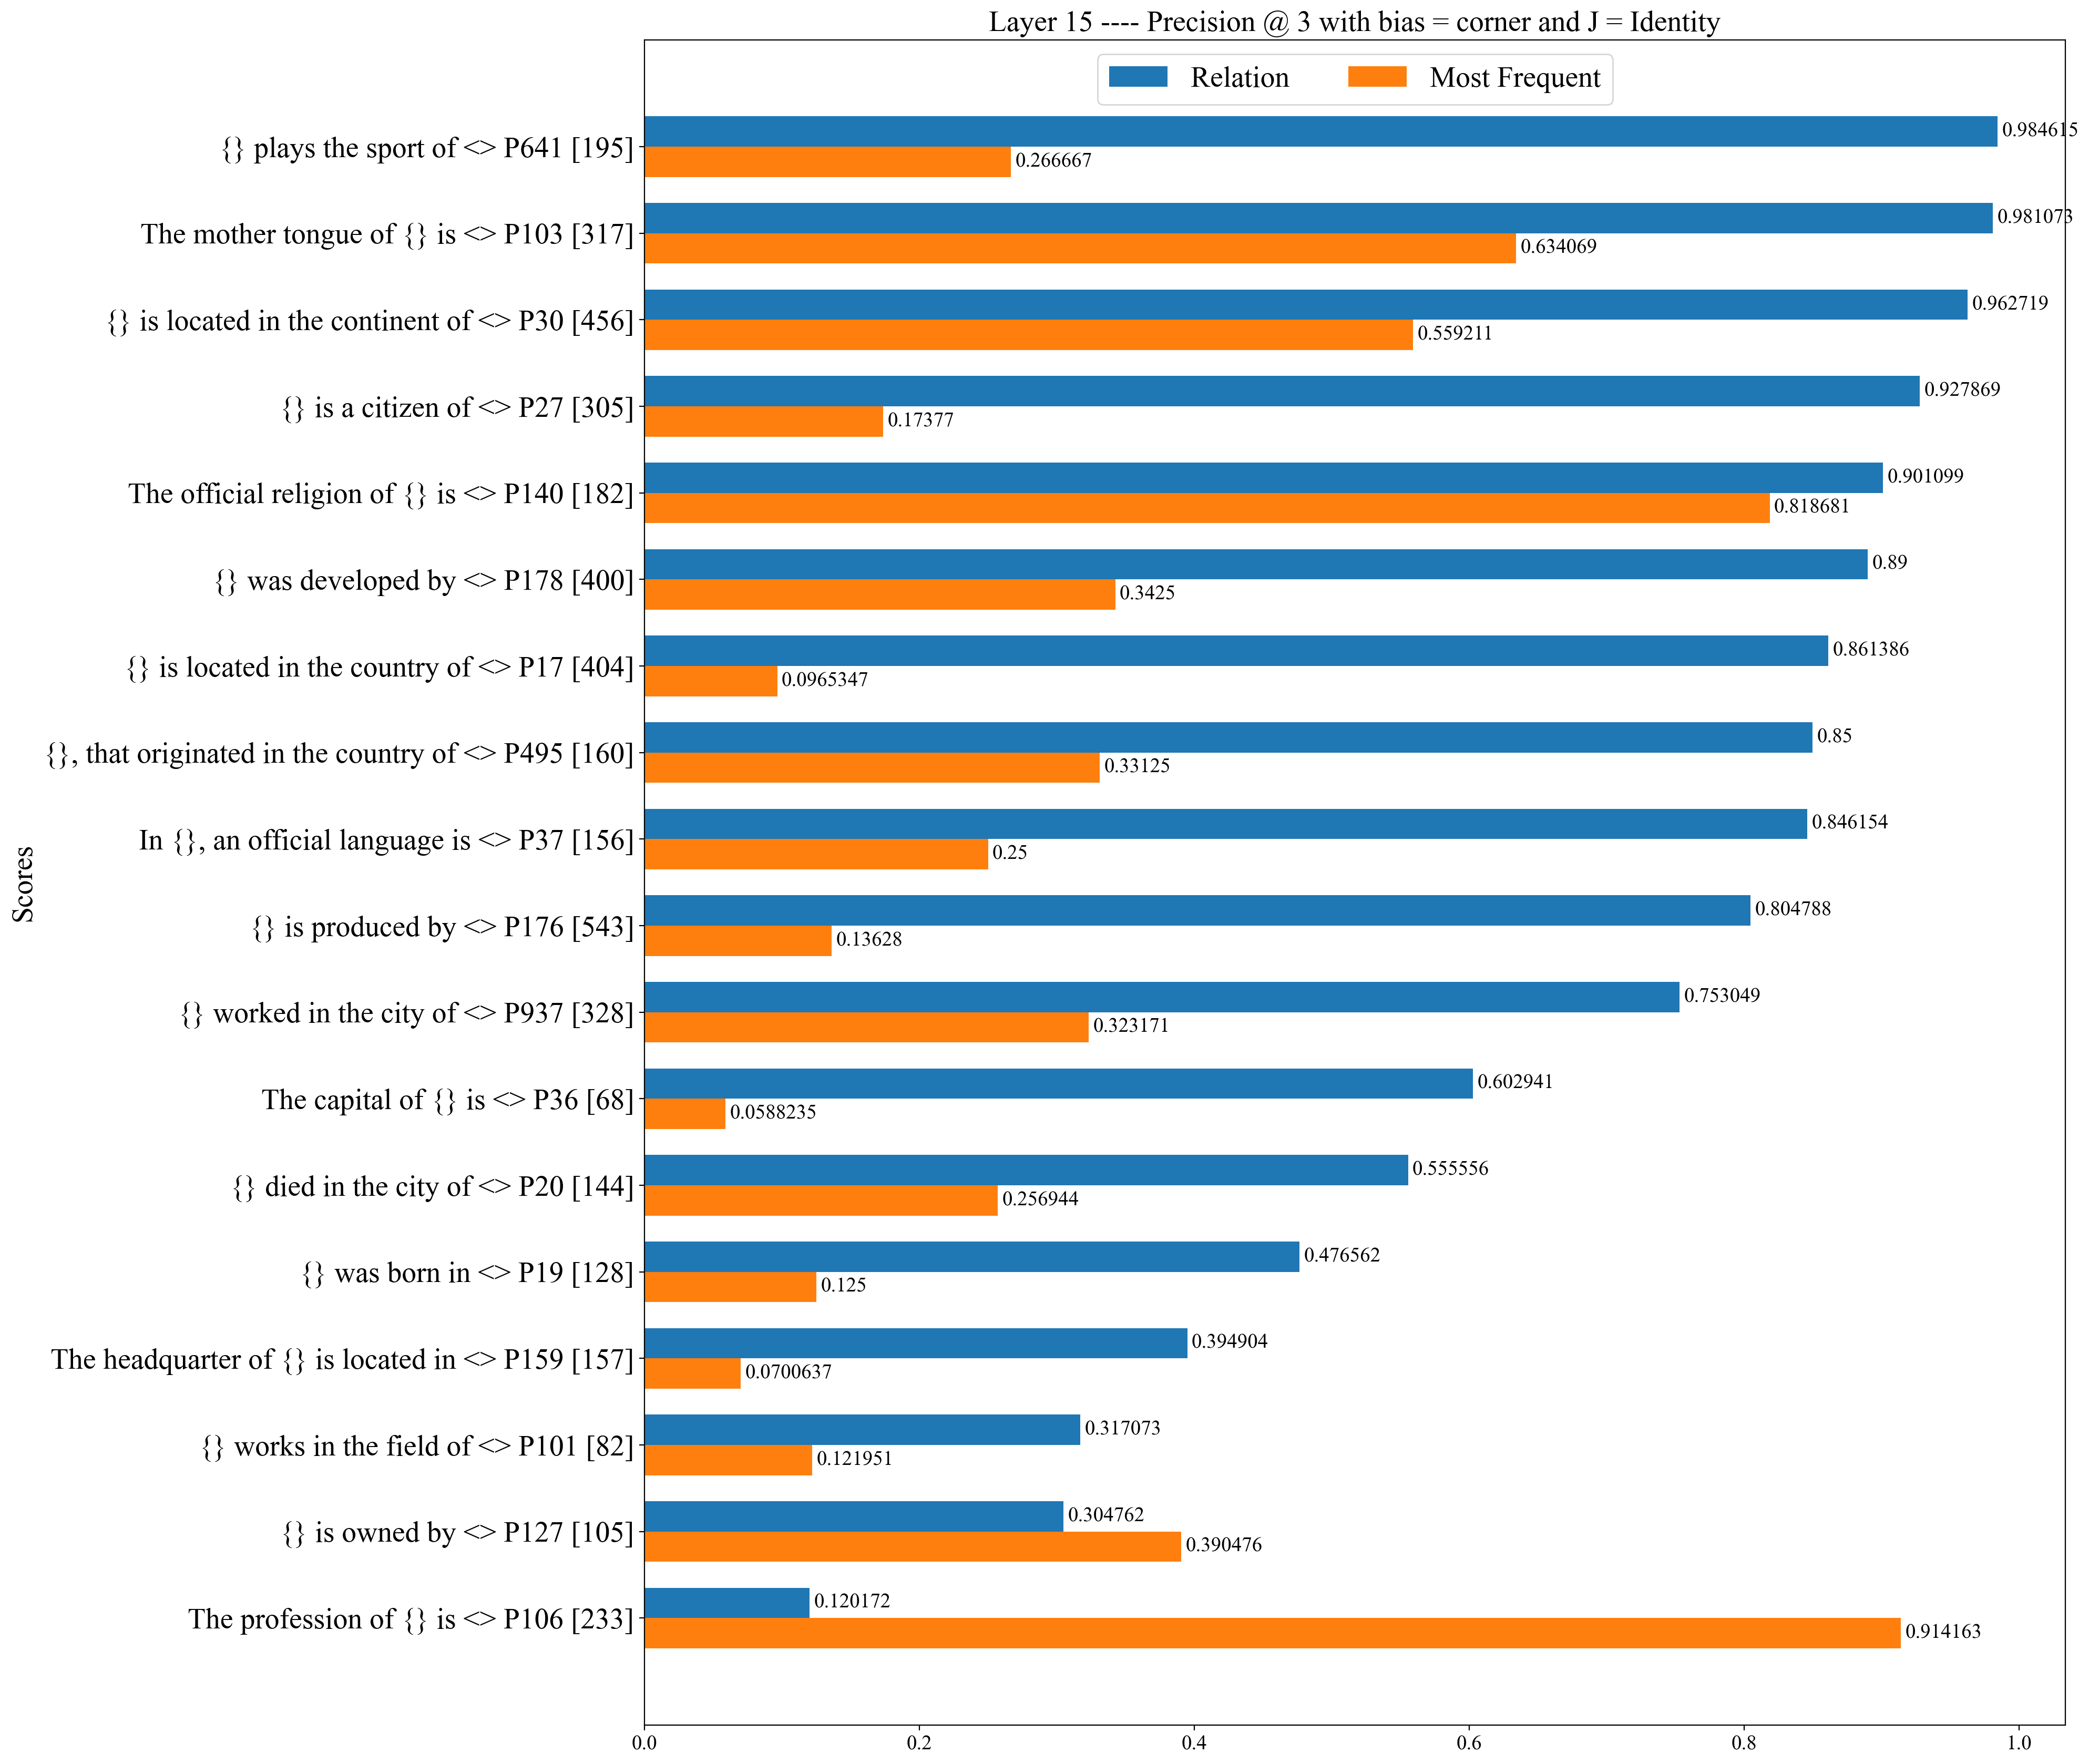

In [65]:
layer = 15
relations, corner_accuracies, freq_accuracies = get_info_for_plotting(accuracy_tracker, layer = layer)
fig = plot_performance_comparison(layer, relations, corner_accuracies, freq_accuracies, save_path="Performance/Layerwise")

# for layer in range(7, 21):
#     relations, corner_accuracies, freq_accuracies = get_info_for_plotting(accuracy_tracker, layer = layer)
#     fig = plot_performance_comparison(layer, relations, corner_accuracies, freq_accuracies, save_path="Performance/Layerwise")

In [66]:
relation_layerwise = {}
layers = list(range(7, 21))
for relation in accuracy_tracker:
    relation_layerwise[relation] = []
    for layer in layers:
        relation_layerwise[relation].append(accuracy_tracker[relation]["corner_acc"][f"layer_{layer}"])

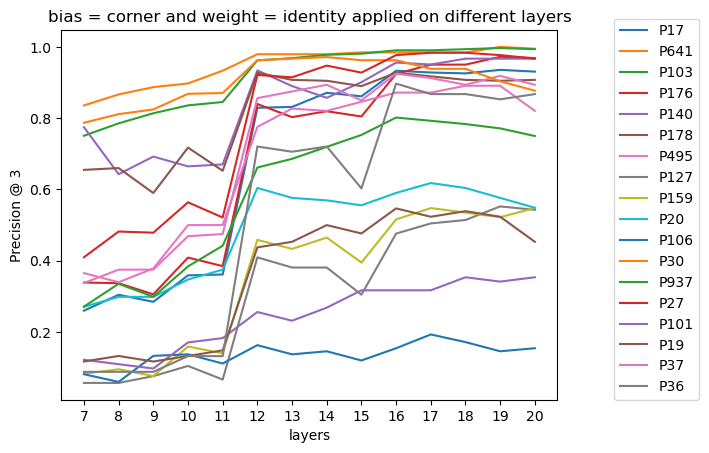

In [70]:
plt.rcdefaults()
for r in relation_layerwise:
    plt.plot(relation_layerwise[r], label = r)
plt.xticks(range(len(layers)), layers)
# plt.legend(loc = "upper right")
plt.ylabel("Precision @ 3")
plt.xlabel("layers")
plt.title("bias = corner and weight = identity applied on different layers")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig("corner_identity_different_layers.png")

## Get Jacobians

In [19]:
layer = 15
number_of_runs = 10
accuracy_tracker = {}

for relation_id in relation_dct:
    print("######################################################################################################")
    print(relation_id, ":", relation_dct[relation_id]["relation"])
    print("######################################################################################################")

    with open(f"{root_path}/{relation_id}/correct_prediction_{relation_id}.json") as f:
        correct_predictions = json.load(f)
    print(f"correctly predicted by {MODEL_NAME}: ", len(correct_predictions))
    if(len(correct_predictions) < cut_off):
        print("SKIPPING >>> len(correct_predictions): ", len(correct_predictions))
        continue

    objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
    objects = [" "+ o['target_true']['str'] for o in objects]
    objects = list(set(objects))
    print("unique objects: ", len(objects), objects[0:min(5, len(objects))])

    # corner = calculate_corner_average(model, tokenizer, objects)
    accuracy_tracker[relation_id] = {
        'out_of'        : len(correct_predictions),
        'identity_acc'  : [],
        'jacobian_acc'  : [],
        'freq_acc'      : None
    }

    print(f"----------------- LAYER {layer} -----------------")

    for _ in tqdm(range(number_of_runs)):
        corner = calculate_corner(model, tokenizer, objects)
        relation_identity = estimate.RelationOperator(
            model = model,
            tokenizer = tokenizer,
            relation = relation_dct[relation_id]['relation'],
            layer = layer,
            weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
            bias = corner
        )
        identity_acc, freq_acc = calculate_accuracy(relation_identity, correct_predictions)
        if accuracy_tracker[relation_id]["freq_acc"] is None:
            accuracy_tracker[relation_id]["freq_acc"] = freq_acc
        accuracy_tracker[relation_id]["identity_acc"].append(identity_acc)
        print(identity_acc)

    cached_file = np.load(f"gpt-j/jacobians_averaged_collection/{relation_id}.npz", allow_pickle= True)
    weights_and_biases = cached_file['weights_and_biases']

    for jb in tqdm(weights_and_biases):
        weight = torch.tensor(jb['weight'])
        # bias = jb["JB"][0]["bias"]

        relation_jacobian = estimate.RelationOperator(
            model = model,
            tokenizer = tokenizer,
            relation = relation_dct[relation_id]['relation'],
            layer = layer,
            weight = weight.to(model.dtype).to(model.device),
            bias = corner
        )
        jacobian_acc, freq_acc = calculate_accuracy(relation_jacobian, correct_predictions)
        accuracy_tracker[relation_id]["jacobian_acc"].append(jacobian_acc)
        print(jacobian_acc)

    identity_acc = np.array(accuracy_tracker[relation_id]["identity_acc"])
    jacobian_acc = np.array(accuracy_tracker[relation_id]["jacobian_acc"])
    print(f"layer {layer} >> corner accuracy: {identity_acc.mean()} +/- {identity_acc.std()}, jacobian_acc: {jacobian_acc.mean()} +/- {jacobian_acc.std()}, freq_acc: {freq_acc} || out of {len(correct_predictions)}")
    # accuracy_tracker[relation_id]["freq_acc"]   = freq_acc
    # print(accuracy_tracker[relation_id])
    print("######################################################################################################")
    print()


######################################################################################################
P17 : {} is located in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  404
unique objects:  95 [' Serbia', ' Oman', ' Qatar', ' Belarus', ' Algeria']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([95, 1])
initial representation:  ['check', ' dere', 'udi', ' charges', 'ision']
final representation:  [' Nigeria', ' Finland', ' Venezuela', ' Ukraine', ' Kenya']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8613861386138614
torch.Size([95, 1])
initial representation:  [' mined', ' bombed', ' miscar', ' snipers', ' misinterpret']
final representation:  [' Cyprus', ' Finland', ' Ukraine', ' Colombia', ' Nigeria']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8688118811881188
torch.Size([95, 1])
initial representation:  [' Kahn', ' Hou', ' Fraser', ' Bradley', 'isle']
final representation:  [' Ukraine', ' Bangladesh', ' Venezuela', ' Cyprus', ' Switzerland']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8589108910891089
torch.Size([95, 1])
initial representation:  ['/"', 'Ky', 'grass', ' j', 'ie']
final representation:  [' Ukraine', ' Bangladesh', ' Nigeria', ' Belgium', ' Malaysia']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8613861386138614
torch.Size([95, 1])
initial representation:  [' universes', 'uster', 'ounds', 'acks', 'aph']
final representation:  [' Ukraine', ' Finland', ' Nigeria', ' Switzerland', ' Argentina']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8663366336633663
torch.Size([95, 1])
initial representation:  [' Pope', ' Alph', ' Bran', ' George', ' Scand']
final representation:  [' Belgium', ' Switzerland', ' Nigeria', ' Ukraine', ' Bangladesh']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8589108910891089
torch.Size([95, 1])
initial representation:  [' *', ' rural', ' legal', ' piece', ' ***']
final representation:  [' Nigeria', ' Belgium', ' Venezuela', ' Haiti', ' Thailand']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8737623762376238
torch.Size([95, 1])
initial representation:  [' con', ' oper', '64', '%', '19']
final representation:  [' Ukraine', ' Finland', ' Belgium', ' Switzerland', ' Nigeria']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8638613861386139
torch.Size([95, 1])
initial representation:  [' Persons', 'iss', 'dan', ' Cause', ' persons']
final representation:  [' Nigeria', ' Haiti', ' Ukraine', ' Belgium', ' Malta']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8613861386138614
torch.Size([95, 1])
initial representation:  ['ira', 'TR', 'zen', 'TC', 'zer']
final representation:  [' Ukraine', ' Finland', ' Belgium', ' Nigeria', ' Thailand']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8613861386138614


  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_1579116/3421107222.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight = torch.tensor(jb['weight'])


  0%|          | 0/404 [00:00<?, ?it/s]

0.7648514851485149


  0%|          | 0/404 [00:00<?, ?it/s]

0.8316831683168316


  0%|          | 0/404 [00:00<?, ?it/s]

0.7945544554455446


  0%|          | 0/404 [00:00<?, ?it/s]

0.6608910891089109


  0%|          | 0/404 [00:00<?, ?it/s]

0.8143564356435643


  0%|          | 0/404 [00:00<?, ?it/s]

0.806930693069307


  0%|          | 0/404 [00:00<?, ?it/s]

0.5816831683168316


  0%|          | 0/404 [00:00<?, ?it/s]

0.7202970297029703


  0%|          | 0/404 [00:00<?, ?it/s]

0.8292079207920792


  0%|          | 0/404 [00:00<?, ?it/s]

0.7029702970297029
layer 15 >> corner accuracy: 0.8636138613861386 +/- 0.004489692363172542, jacobian_acc: 0.7507425742574256 +/- 0.07867277451854635, freq_acc: 0.09653465346534654 || out of 404
######################################################################################################

######################################################################################################
P641 : {} plays the sport of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  195
unique objects:  5 [' soccer', ' baseball', ' football', ' hockey', ' basketball']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([5, 1])
initial representation:  ['less', 'ine', 'Bah', 'Fab', 'rah']
final representation:  [' soccer', ' basketball', ' hockey', ' baseball', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
torch.Size([5, 1])
initial representation:  [' privately', ' </', 'Shock', ' Rew', 'drive']
final representation:  [' basketball', ' soccer', ' hockey', ' baseball', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
torch.Size([5, 1])
initial representation:  [' Unc', ' cloud', ' nor', ' Console', ' Winc']
final representation:  [' baseball', ' hockey', ' soccer', ' basketball', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
torch.Size([5, 1])
initial representation:  [' Union', ' Cup', ' club', ' Club', ' Brooklyn']
final representation:  [' basketball', ' soccer', ' baseball', ' hockey', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
torch.Size([5, 1])
initial representation:  ['DR', ':-', 'FR', ' trade', 'STD']
final representation:  [' basketball', ' baseball', ' hockey', ' soccer', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
torch.Size([5, 1])
initial representation:  ['lab', 'icker', '...', '....', 'baugh']
final representation:  [' basketball', ' baseball', ' hockey', ' soccer', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
torch.Size([5, 1])
initial representation:  ['arten', 'stad', ' formulas', ' unm', ' Masters']
final representation:  [' basketball', ' hockey', ' baseball', ' soccer', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
torch.Size([5, 1])
initial representation:  ['future', 'where', 'LOCK', 'wu', 'PRE']
final representation:  [' basketball', ' soccer', ' baseball', ' hockey', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
torch.Size([5, 1])
initial representation:  [' neighbouring', ' pretended', ' neighboring', ' `', ' charges']
final representation:  [' basketball', ' soccer', ' hockey', ' baseball', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
torch.Size([5, 1])
initial representation:  [' spect', ' optimization', ' Nor', ' Organ', ' implementation']
final representation:  [' basketball', ' baseball', ' soccer', ' hockey', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

0.9230769230769231


  0%|          | 0/195 [00:00<?, ?it/s]

0.8923076923076924


  0%|          | 0/195 [00:00<?, ?it/s]

0.9230769230769231


  0%|          | 0/195 [00:00<?, ?it/s]

0.8769230769230769


  0%|          | 0/195 [00:00<?, ?it/s]

0.8974358974358975


  0%|          | 0/195 [00:00<?, ?it/s]

0.9025641025641026


  0%|          | 0/195 [00:00<?, ?it/s]

0.8102564102564103


  0%|          | 0/195 [00:00<?, ?it/s]

0.9282051282051282


  0%|          | 0/195 [00:00<?, ?it/s]

0.9128205128205128


  0%|          | 0/195 [00:00<?, ?it/s]

0.8923076923076924
layer 15 >> corner accuracy: 0.9846153846153847 +/- 0.0, jacobian_acc: 0.8958974358974359 +/- 0.03251864382048758, freq_acc: 0.26666666666666666 || out of 195
######################################################################################################

######################################################################################################
P103 : The mother tongue of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  317
unique objects:  30 [' Polish', ' Tamil', ' Finnish', ' Latin', ' Spanish']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([30, 1])
initial representation:  ['thy', 'lance', 'Car', 'vacc', ' pac']
final representation:  [' Romanian', ' Spanish', ' Danish', ' Indonesian', ' Greek']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9810725552050473
torch.Size([30, 1])
initial representation:  [' Corpor', ' repeated', ' spoken', ' NON', ' gentlemen']
final representation:  [' Romanian', ' Finnish', ' Hebrew', ' Indonesian', ' Hungarian']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9779179810725552
torch.Size([30, 1])
initial representation:  ['ESA', 'ALT', 'ACC', 'ICO', 'HP']
final representation:  [' Thai', ' Romanian', ' Spanish', ' Turkish', ' Ukrainian']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9716088328075709
torch.Size([30, 1])
initial representation:  [' case', ' grip', 'bane', ' cases', ' bal']
final representation:  [' Danish', ' Romanian', ' Indian', ' Spanish', ' Turkish']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9747634069400631
torch.Size([30, 1])
initial representation:  [' 201', ' coord', '201', 'coord', ' cement']
final representation:  [' Romanian', ' Spanish', ' Greek', ' Swedish', ' Hindi']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9779179810725552
torch.Size([30, 1])
initial representation:  ['anga', 'unch', 'omo', 'itol', 'aken']
final representation:  [' Ukrainian', ' Romanian', ' Spanish', ' Finnish', ' Hebrew']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9810725552050473
torch.Size([30, 1])
initial representation:  [' substitution', 'older', ' intermitt', ' upgrade', ' inconsistency']
final representation:  [' Romanian', ' Japanese', ' Danish', ' Spanish', ' Hungarian']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9747634069400631
torch.Size([30, 1])
initial representation:  ['pless', ' bab', ' kicked', 'ours', ' removed']
final representation:  [' Finnish', ' Romanian', ' Spanish', ' Indonesian', ' Korean']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9810725552050473
torch.Size([30, 1])
initial representation:  [' Vog', ' Unique', ' partition', ' Ren', ' (),']
final representation:  [' Spanish', ' Finnish', ' Romanian', ' Indonesian', ' Danish']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9716088328075709
torch.Size([30, 1])
initial representation:  [' visiting', ' IMAGES', ' FUN', ' blinking', ' upright']
final representation:  [' Romanian', ' Spanish', ' Armenian', ' Serbian', ' Hebrew']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9779179810725552


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

0.9274447949526814


  0%|          | 0/317 [00:00<?, ?it/s]

0.9400630914826499


  0%|          | 0/317 [00:00<?, ?it/s]

0.9274447949526814


  0%|          | 0/317 [00:00<?, ?it/s]

0.943217665615142


  0%|          | 0/317 [00:00<?, ?it/s]

0.9495268138801262


  0%|          | 0/317 [00:00<?, ?it/s]

0.9400630914826499


  0%|          | 0/317 [00:00<?, ?it/s]

0.9621451104100947


  0%|          | 0/317 [00:00<?, ?it/s]

0.9621451104100947


  0%|          | 0/317 [00:00<?, ?it/s]

0.943217665615142


  0%|          | 0/317 [00:00<?, ?it/s]

0.9463722397476341
layer 15 >> corner accuracy: 0.9769716088328074 +/- 0.0034700315457413377, jacobian_acc: 0.9441640378548894 +/- 0.011290555311150334, freq_acc: 0.6340694006309149 || out of 317
######################################################################################################

######################################################################################################
P176 : {} is produced by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  543
unique objects:  37 [' Nissan', ' Honda', ' Bentley', ' Dodge', ' Intel']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([37, 1])
initial representation:  [' outstanding', 'rolling', 'd', 'layout', ' amount']
final representation:  [' Ford', ' Volkswagen', ' Mercedes', ' Toyota', ' Boeing']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8103130755064457
torch.Size([37, 1])
initial representation:  ['service', ' Vict', 'see', ' Lawson', 'select']
final representation:  [' Ford', ' Volkswagen', ' Mercedes', ' Chrysler', ' Toyota']


  0%|          | 0/543 [00:00<?, ?it/s]

0.7992633517495396
torch.Size([37, 1])
initial representation:  ['hart', 'iatus', ' LET', ' Hem', ' reversed']
final representation:  [' Ford', ' Mercedes', ' Audi', ' Boeing', ' Toyota']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8066298342541437
torch.Size([37, 1])
initial representation:  ['Fine', 'Bo', ' Wer', ' compiled', 'kos']
final representation:  [' Ford', ' Mercedes', ' Toyota', ' Boeing', ' Chrysler']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8066298342541437
torch.Size([37, 1])
initial representation:  [' adapt', 'Requ', '*', ' Schneider', '\\-']
final representation:  [' Ford', ' Mercedes', ' Boeing', ' Audi', ' Toyota']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8011049723756906
torch.Size([37, 1])
initial representation:  [' group', ' heavy', ' regime', ' unw', ' enz']
final representation:  [' Ford', ' Mercedes', ' Volkswagen', ' Chrysler', ' Boeing']


  0%|          | 0/543 [00:00<?, ?it/s]

0.7863720073664825
torch.Size([37, 1])
initial representation:  ['atcher', ' contingency', ' IG', ' DW', ' dow']
final representation:  [' Ford', ' Mercedes', ' Audi', ' Volkswagen', ' Boeing']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8084714548802947
torch.Size([37, 1])
initial representation:  [' Medium', '106', '105', 'Medium', 'lder']
final representation:  [' Ford', ' Mercedes', ' Boeing', ' Chrysler', ' Toyota']


  0%|          | 0/543 [00:00<?, ?it/s]

0.7882136279926335
torch.Size([37, 1])
initial representation:  ['lect', 'blog', 'house', 'ara', 'any']
final representation:  [' Ford', ' Mercedes', ' Audi', ' Volkswagen', ' Boeing']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8047882136279927
torch.Size([37, 1])
initial representation:  ['IO', ' 99', ' File', ' Series', ' 98']
final representation:  [' Ford', ' Mercedes', ' Boeing', ' Toyota', ' Volvo']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8066298342541437


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

0.06998158379373849


  0%|          | 0/543 [00:00<?, ?it/s]

0.4162062615101289


  0%|          | 0/543 [00:00<?, ?it/s]

0.17679558011049723


  0%|          | 0/543 [00:00<?, ?it/s]

0.48987108655616945


  0%|          | 0/543 [00:00<?, ?it/s]

0.4088397790055249


  0%|          | 0/543 [00:00<?, ?it/s]

0.3001841620626151


  0%|          | 0/543 [00:00<?, ?it/s]

0.08103130755064457


  0%|          | 0/543 [00:00<?, ?it/s]

0.4419889502762431


  0%|          | 0/543 [00:00<?, ?it/s]

0.4972375690607735


  0%|          | 0/543 [00:00<?, ?it/s]

0.5469613259668509
layer 15 >> corner accuracy: 0.8018416206261512 +/- 0.007908254347544736, jacobian_acc: 0.3429097605893186 +/- 0.16705600465582657, freq_acc: 0.13627992633517497 || out of 543
######################################################################################################

######################################################################################################
P140 : The official religion of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  182
unique objects:  9 [' Christianity', ' Catholicism', ' Muslim', ' Scientology', ' Christian']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([9, 1])
initial representation:  ['core', 'azo', 'blue', 'house', 'query']
final representation:  [' Christianity', ' Scientology', ' Muslim', ' Catholicism', ' Judaism']


  0%|          | 0/182 [00:00<?, ?it/s]

0.8956043956043956
torch.Size([9, 1])
initial representation:  [' Den', 'ers', 'gu', ' Su', ' Grav']
final representation:  [' Christianity', ' Scientology', ' Muslim', ' Catholicism', ' Christian']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341
torch.Size([9, 1])
initial representation:  [' existing', ' schedule', 'FI', 'Mods', ' otherwise']
final representation:  [' Scientology', ' Christianity', ' Muslim', ' Catholicism', ' Christian']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9175824175824175
torch.Size([9, 1])
initial representation:  ['hare', 'er', 'ger', 'athe', 'ystem']
final representation:  [' Christianity', ' Scientology', ' Catholicism', ' Islam', ' Judaism']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9230769230769231
torch.Size([9, 1])
initial representation:  ['tx', ' bi', 'obi', 'alloc', 'umper']
final representation:  [' Christianity', ' Scientology', ' Muslim', ' Islam', ' Catholicism']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9120879120879121
torch.Size([9, 1])
initial representation:  [' record', ' exp', ' appeals', ' appeal', ' cord']
final representation:  [' Christianity', ' Scientology', ' Catholicism', ' Islam', ' Muslim']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9395604395604396
torch.Size([9, 1])
initial representation:  [' View', 'ing', ' Wide', 'Beg', 'ل']
final representation:  [' Christianity', ' Scientology', ' Muslim', ' Catholicism', ' Judaism']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341
torch.Size([9, 1])
initial representation:  ['Back', ' lab', ' J', 'North', ' RO']
final representation:  [' Catholic', ' Buddhist', ' Scientology', ' Christianity', ' Muslim']


  0%|          | 0/182 [00:00<?, ?it/s]

0.8846153846153846
torch.Size([9, 1])
initial representation:  [' STAND', 'alli', 'OPS', 'amina', ' releasing']
final representation:  [' Christianity', ' Scientology', ' Muslim', ' Catholicism', ' Judaism']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9010989010989011
torch.Size([9, 1])
initial representation:  ['kowski', ' Posted', 'ETA', ' gamb', ' RSS']
final representation:  [' Scientology', ' Christianity', ' Muslim', ' Catholicism', ' Christian']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9175824175824175


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

0.989010989010989


  0%|          | 0/182 [00:00<?, ?it/s]

0.989010989010989


  0%|          | 0/182 [00:00<?, ?it/s]

0.978021978021978


  0%|          | 0/182 [00:00<?, ?it/s]

0.978021978021978


  0%|          | 0/182 [00:00<?, ?it/s]

0.989010989010989


  0%|          | 0/182 [00:00<?, ?it/s]

0.9835164835164835


  0%|          | 0/182 [00:00<?, ?it/s]

0.978021978021978


  0%|          | 0/182 [00:00<?, ?it/s]

0.978021978021978


  0%|          | 0/182 [00:00<?, ?it/s]

0.978021978021978


  0%|          | 0/182 [00:00<?, ?it/s]

0.967032967032967
layer 15 >> corner accuracy: 0.915934065934066 +/- 0.017032967032967035, jacobian_acc: 0.9807692307692308 +/- 0.006616260757578202, freq_acc: 0.8186813186813187 || out of 182
######################################################################################################

######################################################################################################
P178 : {} was developed by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  400
unique objects:  19 [' Square', ' Samsung', ' Intel', ' Airbus', ' Microsoft']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([19, 1])
initial representation:  ['Fact', 'Path', 'Video', 'Planet', 'Can']
final representation:  [' Samsung', ' Airbus', ' Sony', ' IBM', ' Nintendo']


  0%|          | 0/400 [00:00<?, ?it/s]

0.9
torch.Size([19, 1])
initial representation:  ['ots', ' cy', ' Alam', ' rebels', ' Barton']
final representation:  [' Samsung', ' Airbus', ' Nintendo', ' Sony', ' IBM']


  0%|          | 0/400 [00:00<?, ?it/s]

0.9025
torch.Size([19, 1])
initial representation:  ['quer', ' opp', 'END', 'ilt', 'USER']
final representation:  [' Samsung', ' Nokia', ' IBM', ' Nintendo', ' Airbus']


  0%|          | 0/400 [00:00<?, ?it/s]

0.9025
torch.Size([19, 1])
initial representation:  [' conversion', ' teaching', ' treating', ' degree', ' abuse']
final representation:  [' Airbus', ' Samsung', ' Nokia', ' Nintendo', ' Sony']


  0%|          | 0/400 [00:00<?, ?it/s]

0.9075
torch.Size([19, 1])
initial representation:  ['shock', 'lime', 'inc', '4000', 'boost']
final representation:  [' Airbus', ' Nintendo', ' IBM', ' Samsung', ' Nokia']


  0%|          | 0/400 [00:00<?, ?it/s]

0.8975
torch.Size([19, 1])
initial representation:  ['Tip', 'gie', 'gs', 'rr', 'ts']
final representation:  [' Sony', ' Nintendo', ' IBM', ' Samsung', ' Nokia']


  0%|          | 0/400 [00:00<?, ?it/s]

0.905
torch.Size([19, 1])
initial representation:  [' bounced', ' rebound', '++', 'Stan', ' recomp']
final representation:  [' Samsung', ' Airbus', ' Sony', ' Nintendo', ' IBM']


  0%|          | 0/400 [00:00<?, ?it/s]

0.9075
torch.Size([19, 1])
initial representation:  ['arth', 'phal', 'art', 'aten', 'ac']
final representation:  [' Nintendo', ' Airbus', ' Sony', ' Samsung', ' IBM']


  0%|          | 0/400 [00:00<?, ?it/s]

0.9
torch.Size([19, 1])
initial representation:  ['Sleep', 'Log', ' values', ' value', ' belie']
final representation:  [' Samsung', ' Airbus', ' IBM', ' Sony', ' Nintendo']


  0%|          | 0/400 [00:00<?, ?it/s]

0.8875
torch.Size([19, 1])
initial representation:  ['BP', ' summary', 'summary', ' >>', '>>']
final representation:  [' Airbus', ' Nintendo', ' IBM', ' Sony', ' Nokia']


  0%|          | 0/400 [00:00<?, ?it/s]

0.89


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

0.5025


  0%|          | 0/400 [00:00<?, ?it/s]

0.805


  0%|          | 0/400 [00:00<?, ?it/s]

0.4


  0%|          | 0/400 [00:00<?, ?it/s]

0.305


  0%|          | 0/400 [00:00<?, ?it/s]

0.52


  0%|          | 0/400 [00:00<?, ?it/s]

0.59


  0%|          | 0/400 [00:00<?, ?it/s]

0.315


  0%|          | 0/400 [00:00<?, ?it/s]

0.64


  0%|          | 0/400 [00:00<?, ?it/s]

0.765


  0%|          | 0/400 [00:00<?, ?it/s]

0.26
layer 15 >> corner accuracy: 0.9 +/- 0.0064226162893325665, jacobian_acc: 0.51025 +/- 0.18170185056845184, freq_acc: 0.3425 || out of 400
######################################################################################################

######################################################################################################
P495 : {}, that originated in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  160
unique objects:  67 [' Argentina', ' Scotland', ' Japan', ' Singapore', ' Sweden']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([67, 1])
initial representation:  [' tet', ' invented', ' syn', ' culture', ' suspension']
final representation:  [' Nigeria', ' Thailand', ' Ireland', ' Lebanon', ' Belgium']


  0%|          | 0/160 [00:00<?, ?it/s]

0.88125
torch.Size([67, 1])
initial representation:  ['EC', 'nob', '1016', 'Finally', 'empty']
final representation:  [' Nigeria', ' Thailand', ' Lebanon', ' Ireland', ' Ukraine']


  0%|          | 0/160 [00:00<?, ?it/s]

0.8625
torch.Size([67, 1])
initial representation:  ['ui', ' fraction', 'ily', 'AD', 'ye']
final representation:  [' Ethiopia', ' Belgium', ' Thailand', ' Nigeria', ' Colombia']


  0%|          | 0/160 [00:00<?, ?it/s]

0.8625
torch.Size([67, 1])
initial representation:  [' Due', ' Thin', ' Proceed', ' Thick', ' Materials']
final representation:  [' Nigeria', ' Thailand', ' Ireland', ' Belgium', ' Spain']


  0%|          | 0/160 [00:00<?, ?it/s]

0.86875
torch.Size([67, 1])
initial representation:  [' hon', ' lad', 'ldon', 'ick', ' backed']
final representation:  [' Nigeria', ' Lebanon', ' Thailand', ' Ireland', ' Colombia']


  0%|          | 0/160 [00:00<?, ?it/s]

0.875
torch.Size([67, 1])
initial representation:  ['ation', 'ification', 'ual', ' ', 'Catalog']
final representation:  [' Romania', ' Thailand', ' Ireland', ' Ukraine', ' Colombia']


  0%|          | 0/160 [00:00<?, ?it/s]

0.86875
torch.Size([67, 1])
initial representation:  [' Accountability', 'amer', ' Grove', 'suit', ' George']
final representation:  [' Nigeria', ' Thailand', ' Lebanon', ' Ireland', ' Colombia']


  0%|          | 0/160 [00:00<?, ?it/s]

0.85625
torch.Size([67, 1])
initial representation:  ['ay', '110', 'ai', 'pi', '.*']
final representation:  [' Ireland', ' Thailand', ' Lebanon', ' Finland', ' Romania']


  0%|          | 0/160 [00:00<?, ?it/s]

0.8625
torch.Size([67, 1])
initial representation:  ['serial', 'alog', 'aur', 'ms', ' SL']
final representation:  [' Thailand', ' Lebanon', ' Belgium', ' Ireland', ' Romania']


  0%|          | 0/160 [00:00<?, ?it/s]

0.86875
torch.Size([67, 1])
initial representation:  ['Euro', 'ulet', ' URL', 'url', 'Mur']
final representation:  [' Thailand', ' Nigeria', ' Ireland', ' Lebanon', ' Colombia']


  0%|          | 0/160 [00:00<?, ?it/s]

0.8625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

0.83125


  0%|          | 0/160 [00:00<?, ?it/s]

0.74375


  0%|          | 0/160 [00:00<?, ?it/s]

0.71875


  0%|          | 0/160 [00:00<?, ?it/s]

0.8875


  0%|          | 0/160 [00:00<?, ?it/s]

0.74375


  0%|          | 0/160 [00:00<?, ?it/s]

0.75


  0%|          | 0/160 [00:00<?, ?it/s]

0.85


  0%|          | 0/160 [00:00<?, ?it/s]

0.76875


  0%|          | 0/160 [00:00<?, ?it/s]

0.75


  0%|          | 0/160 [00:00<?, ?it/s]

0.85
layer 15 >> corner accuracy: 0.8668750000000001 +/- 0.006874999999999993, jacobian_acc: 0.7893749999999999 +/- 0.05604476447448056, freq_acc: 0.33125 || out of 160
######################################################################################################

######################################################################################################
P127 : {} is owned by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  105
unique objects:  109 [' Jakarta', ' Mobile', ' Volvo', ' Google', ' Houston']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([109, 1])
initial representation:  [' no', 'lean', ' sust', 'ation', ' car']
final representation:  [' Amsterdam', ' Japan', ' Arizona', ' Singapore', ' Florida']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3047619047619048
torch.Size([109, 1])
initial representation:  ['zel', 'words', 'prime', 'word', 'Sel']
final representation:  [' Arizona', ' Japan', ' Florida', ' Singapore', ' Dubai']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3238095238095238
torch.Size([109, 1])
initial representation:  ['ib', 'omy', 'inks', 'ful', 'io']
final representation:  [' Japan', ' Moscow', ' Arizona', ' Amsterdam', ' Washington']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3142857142857143
torch.Size([109, 1])
initial representation:  [' registered', ' wrapper', ' bug', ' Registered', 'ati']
final representation:  [' Arizona', ' Boston', ' Japan', ' San', ' Washington']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3047619047619048
torch.Size([109, 1])
initial representation:  ['ital', ' interface', 'out', 'Al', 'x']
final representation:  [' Amsterdam', ' Washington', ' Florida', ' Arizona', ' Japan']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3333333333333333
torch.Size([109, 1])
initial representation:  ['655', '×', 'estate', 'ppo', '880']
final representation:  [' Florida', ' Arizona', ' Japan', ' Miami', ' Washington']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3047619047619048
torch.Size([109, 1])
initial representation:  ['Stock', 'hi', 'Text', 'Ind', 'stock']
final representation:  [' Japan', ' Arizona', ' Singapore', ' Barcelona', ' Amsterdam']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3238095238095238
torch.Size([109, 1])
initial representation:  ['wp', 'nor', 'kr', ' Darrell', 'igon']
final representation:  [' Amsterdam', ' Japan', ' Miami', ' Florida', ' Singapore']


  0%|          | 0/105 [00:00<?, ?it/s]

0.29523809523809524
torch.Size([109, 1])
initial representation:  ['ota', '56', ' +=', 'ax', 'syn']
final representation:  [' Amsterdam', ' San', ' Washington', ' Arizona', ' Japan']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3238095238095238
torch.Size([109, 1])
initial representation:  ['ec', 'ck', ' policies', ' inf', ' exposures']
final representation:  [' Arizona', ' Japan', ' Moscow', ' Florida', ' San']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3142857142857143


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

0.047619047619047616


  0%|          | 0/105 [00:00<?, ?it/s]

0.01904761904761905


  0%|          | 0/105 [00:00<?, ?it/s]

0.08571428571428572


  0%|          | 0/105 [00:00<?, ?it/s]

0.06666666666666667


  0%|          | 0/105 [00:00<?, ?it/s]

0.0761904761904762


  0%|          | 0/105 [00:00<?, ?it/s]

0.17142857142857143


  0%|          | 0/105 [00:00<?, ?it/s]

0.08571428571428572


  0%|          | 0/105 [00:00<?, ?it/s]

0.10476190476190476


  0%|          | 0/105 [00:00<?, ?it/s]

0.09523809523809523


  0%|          | 0/105 [00:00<?, ?it/s]

0.10476190476190476
layer 15 >> corner accuracy: 0.31428571428571433 +/- 0.011268723396380213, jacobian_acc: 0.08571428571428572 +/- 0.0380952380952381, freq_acc: 0.3904761904761905 || out of 105
######################################################################################################

######################################################################################################
P159 : The headquarter of {} is located in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  157
unique objects:  178 [' Scotland', ' Greenwich', ' Shanghai', ' Dortmund', ' Cambridge']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([178, 1])
initial representation:  ['\xad', '@', 'houses', '_', 'Host']
final representation:  [' San', ' Washington', ' Richmond', ' Lebanon', ' Denmark']


  0%|          | 0/157 [00:00<?, ?it/s]

0.3821656050955414
torch.Size([178, 1])
initial representation:  [' core', ' formation', ' bead', ' scr', ' gal']
final representation:  [' South', ' Denmark', ' Richmond', ' Athens', ' Portland']


  0%|          | 0/157 [00:00<?, ?it/s]

0.3503184713375796
torch.Size([178, 1])
initial representation:  [' Sec', ' Def', 'izations', 'head', ' Robinson']
final representation:  [' Washington', ' Richmond', ' San', ' West', ' Berlin']


  0%|          | 0/157 [00:00<?, ?it/s]

0.36942675159235666
torch.Size([178, 1])
initial representation:  ['Later', ' Sub', '010', ' Ly', 'KE']
final representation:  [' San', ' Washington', ' Richmond', ' South', ' Santa']


  0%|          | 0/157 [00:00<?, ?it/s]

0.3630573248407643
torch.Size([178, 1])
initial representation:  [' division', ' "\\', 'haw', ' rights', ' basic']
final representation:  [' South', ' Lebanon', ' Birmingham', ' Windsor', ' Washington']


  0%|          | 0/157 [00:00<?, ?it/s]

0.36942675159235666
torch.Size([178, 1])
initial representation:  ['bt', ' Cart', ' great', ' index', ' study']
final representation:  [' Washington', ' Denmark', ' Richmond', ' Newport', ' Birmingham']


  0%|          | 0/157 [00:00<?, ?it/s]

0.3821656050955414
torch.Size([178, 1])
initial representation:  ['\t', 'ver', 'ros', 'ables', 'ished']
final representation:  [' Washington', ' South', ' Amsterdam', ' Santa', ' Kansas']


  0%|          | 0/157 [00:00<?, ?it/s]

0.35668789808917195
torch.Size([178, 1])
initial representation:  [' blink', 'acked', ' mov', 'urb', 'oris']
final representation:  [' Washington', ' San', ' South', ' Birmingham', ' Berlin']


  0%|          | 0/157 [00:00<?, ?it/s]

0.39490445859872614
torch.Size([178, 1])
initial representation:  ['bu', ' Chou', 'asu', ' Instructor', 'peat']
final representation:  [' Washington', ' San', ' Athens', ' Lebanon', ' Richmond']


  0%|          | 0/157 [00:00<?, ?it/s]

0.36942675159235666
torch.Size([178, 1])
initial representation:  [' Mol', 'ise', ' Lum', 'rag', ' Mé']
final representation:  [' Portland', ' Washington', ' Berlin', ' Birmingham', ' South']


  0%|          | 0/157 [00:00<?, ?it/s]

0.3503184713375796


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.6624203821656051


  0%|          | 0/157 [00:00<?, ?it/s]

0.7070063694267515


  0%|          | 0/157 [00:00<?, ?it/s]

0.7133757961783439


  0%|          | 0/157 [00:00<?, ?it/s]

0.7388535031847133


  0%|          | 0/157 [00:00<?, ?it/s]

0.7006369426751592


  0%|          | 0/157 [00:00<?, ?it/s]

0.6751592356687898


  0%|          | 0/157 [00:00<?, ?it/s]

0.6751592356687898


  0%|          | 0/157 [00:00<?, ?it/s]

0.643312101910828


  0%|          | 0/157 [00:00<?, ?it/s]

0.6751592356687898


  0%|          | 0/157 [00:00<?, ?it/s]

0.6305732484076433
layer 15 >> corner accuracy: 0.3687898089171975 +/- 0.013793890336119583, jacobian_acc: 0.6821656050955414 +/- 0.031391647211086886, freq_acc: 0.07006369426751592 || out of 157
######################################################################################################

######################################################################################################
P20 : {} died in the city of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  144
unique objects:  169 [' Guam', ' Morris', ' Caucasus', ' Idaho', ' Shanghai']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([169, 1])
initial representation:  [' Stage', ' stage', ' phase', ' _', ' Sparks']
final representation:  [' Lebanon', ' Albany', ' South', ' Georgia', ' Moscow']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5694444444444444
torch.Size([169, 1])
initial representation:  ['rha', 'ly', 'r', ' Design', ' trades']
final representation:  [' Lebanon', ' Cairo', ' Albany', ' Athens', ' South']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5902777777777778
torch.Size([169, 1])
initial representation:  ['Reg', 'EST', 'Mult', 'Bel', ' Sett']
final representation:  [' Washington', ' Moscow', ' Cape', ' Alaska', ' Cairo']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5972222222222222
torch.Size([169, 1])
initial representation:  ['IC', '\x0c', 'log', 'fitted', ' interpreter']
final representation:  [' Lebanon', ' Cairo', ' Albany', ' Moscow', ' Alaska']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5763888888888888
torch.Size([169, 1])
initial representation:  [' mild', ' substance', 'old', ' stability', ' memory']
final representation:  [' Lebanon', ' Cape', ' Alaska', ' Washington', ' Cairo']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5833333333333334
torch.Size([169, 1])
initial representation:  [' Gon', 'ush', 'plete', 'Operation', 'Clock']
final representation:  [' Cairo', ' Lebanon', ' Cape', ' Alaska', ' Athens']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5833333333333334
torch.Size([169, 1])
initial representation:  [' integration', 'reen', ' Integration', 'ryn', ' divor']
final representation:  [' Lebanon', ' Cairo', ' Tucson', ' Albany', ' Georgia']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5555555555555556
torch.Size([169, 1])
initial representation:  ['lund', ' Loss', 'ARP', 'DW', 'rw']
final representation:  [' Lebanon', ' Manila', ' Florida', ' Cairo', ' Athens']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5625
torch.Size([169, 1])
initial representation:  ['Begin', 'Visual', 'Gameplay', 'Memory', ' Hardcore']
final representation:  [' Lebanon', ' Cape', ' Washington', ' Athens', ' Arizona']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5902777777777778
torch.Size([169, 1])
initial representation:  [' losses', ' career', ' losers', ' revision', ' Networks']
final representation:  [' Lebanon', ' Cairo', ' Alaska', ' Athens', ' Washington']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5972222222222222


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

0.06944444444444445


  0%|          | 0/144 [00:00<?, ?it/s]

0.2847222222222222


  0%|          | 0/144 [00:00<?, ?it/s]

0.3958333333333333


  0%|          | 0/144 [00:00<?, ?it/s]

0.034722222222222224


  0%|          | 0/144 [00:00<?, ?it/s]

0.041666666666666664


  0%|          | 0/144 [00:00<?, ?it/s]

0.09722222222222222


  0%|          | 0/144 [00:00<?, ?it/s]

0.3194444444444444


  0%|          | 0/144 [00:00<?, ?it/s]

0.5277777777777778


  0%|          | 0/144 [00:00<?, ?it/s]

0.1111111111111111


  0%|          | 0/144 [00:00<?, ?it/s]

0.0625
layer 15 >> corner accuracy: 0.5805555555555555 +/- 0.013608276348795434, jacobian_acc: 0.19444444444444445 +/- 0.16544692558396237, freq_acc: 0.2569444444444444 || out of 144
######################################################################################################

######################################################################################################
P106 : The profession of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  233
unique objects:  31 [' psychologist', ' architect', ' astronaut', ' rabbi', ' actor']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([31, 1])
initial representation:  ['ranging', 'middle', 'screen', 'reference', 'back']
final representation:  [' scientist', ' writer', ' historian', ' researcher', ' doctor']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12446351931330472
torch.Size([31, 1])
initial representation:  [' dummy', ' unm', 'patch', ' polarized', ' polar']
final representation:  [' scientist', ' writer', ' director', ' doctor', ' professor']


  0%|          | 0/233 [00:00<?, ?it/s]

0.11587982832618025
torch.Size([31, 1])
initial representation:  [' gel', ' sticking', ' sticky', 'embed', 'Training']
final representation:  [' scientist', ' writer', ' doctor', ' historian', ' researcher']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695
torch.Size([31, 1])
initial representation:  [' Cord', ' Ariel', 'imer', ' doctrine', ' stud']
final representation:  [' scientist', ' writer', ' director', ' doctor', ' researcher']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12446351931330472
torch.Size([31, 1])
initial representation:  ['MT', '..', ' working', ' &', ' Pul']
final representation:  [' scientist', ' writer', ' doctor', ' director', ' novelist']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695
torch.Size([31, 1])
initial representation:  [' dump', ' takedown', ' 440', ' bear', ' gunshot']
final representation:  [' scientist', ' writer', ' director', ' doctor', ' historian']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12017167381974249
torch.Size([31, 1])
initial representation:  [' Fore', ' Cl', ' IT', "'s", ' Slam']
final representation:  [' scientist', ' doctor', ' writer', ' director', ' professor']


  0%|          | 0/233 [00:00<?, ?it/s]

0.11587982832618025
torch.Size([31, 1])
initial representation:  ['oper', 'ens', 'ignore', 'ude', 'intent']
final representation:  [' scientist', ' writer', ' historian', ' director', ' professor']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12446351931330472
torch.Size([31, 1])
initial representation:  [' out', 'out', ' Warm', 'screen', 'outs']
final representation:  [' scientist', ' writer', ' doctor', ' professor', ' researcher']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12017167381974249
torch.Size([31, 1])
initial representation:  ['config', 'ady', 'bur', 'apa', 'STATE']
final representation:  [' scientist', ' writer', ' director', ' doctor', ' historian']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12017167381974249


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.0
layer 15 >> corner accuracy: 0.1223175965665236 +/- 0.004397832946763776, jacobian_acc: 0.0 +/- 0.0, freq_acc: 0.9141630901287554 || out of 233
######################################################################################################

######################################################################################################
P30 : {} is located in the continent of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  456
unique objects:  5 [' Antarctica', ' Europe', ' Americas', ' Africa', ' Asia']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([5, 1])
initial representation:  ['ach', 'ould', ' ear', ' extract', 'ven']
final representation:  [' Africa', ' Americas', ' Asia', ' Antarctica', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9605263157894737
torch.Size([5, 1])
initial representation:  [' ar', ' expert', ' gen', ' Household', ' hierarch']
final representation:  [' Asia', ' Europe', ' Africa', ' Americas', ' Antarctica']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9583333333333334
torch.Size([5, 1])
initial representation:  [' circ', ' posit', ' Tradition', ' skim', ' Sentinel']
final representation:  [' Africa', ' Asia', ' Europe', ' Americas', ' Antarctica']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9583333333333334
torch.Size([5, 1])
initial representation:  ['oda', ' Dra', ' Plan', 'ayers', ' Gu']
final representation:  [' Antarctica', ' Americas', ' Africa', ' Asia', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9627192982456141
torch.Size([5, 1])
initial representation:  [' study', 'oug', 'study', ' Arch', ' Domin']
final representation:  [' Asia', ' Africa', ' Europe', ' Americas', ' Antarctica']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9605263157894737
torch.Size([5, 1])
initial representation:  ['review', 'mo', 'vo', 'cow', 'ote']
final representation:  [' Asia', ' Africa', ' Antarctica', ' Americas', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9627192982456141
torch.Size([5, 1])
initial representation:  ['jo', ' McN', ' Drop', ' Mans', 'omic']
final representation:  [' Antarctica', ' Americas', ' Africa', ' Asia', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

0.956140350877193
torch.Size([5, 1])
initial representation:  [' fing', ' horns', ' colors', ' stripes', ' MED']
final representation:  [' Asia', ' Africa', ' Americas', ' Antarctica', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9627192982456141
torch.Size([5, 1])
initial representation:  [' male', ' Cad', ' scrub', ' cad', 'lest']
final representation:  [' Africa', ' Americas', ' Antarctica', ' Asia', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9605263157894737
torch.Size([5, 1])
initial representation:  [' Glac', ' Hive', ' Oh', 'env', ' collaps']
final representation:  [' Americas', ' Antarctica', ' Africa', ' Asia', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9583333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/456 [00:00<?, ?it/s]

0.9517543859649122


  0%|          | 0/456 [00:00<?, ?it/s]

0.9539473684210527


  0%|          | 0/456 [00:00<?, ?it/s]

0.9517543859649122


  0%|          | 0/456 [00:00<?, ?it/s]

0.9627192982456141


  0%|          | 0/456 [00:00<?, ?it/s]

0.9495614035087719


  0%|          | 0/456 [00:00<?, ?it/s]

0.9495614035087719


  0%|          | 0/456 [00:00<?, ?it/s]

0.9583333333333334


  0%|          | 0/456 [00:00<?, ?it/s]

0.9473684210526315


  0%|          | 0/456 [00:00<?, ?it/s]

0.9473684210526315


  0%|          | 0/456 [00:00<?, ?it/s]

0.9583333333333334
layer 15 >> corner accuracy: 0.9600877192982458 +/- 0.0021486752129677134, jacobian_acc: 0.9530701754385966 +/- 0.004923233403649954, freq_acc: 0.5592105263157895 || out of 456
######################################################################################################

######################################################################################################
P937 : {} worked in the city of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  328
unique objects:  90 [' Scotland', ' Dortmund', ' Cambridge', ' Jakarta', ' Sheffield']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([90, 1])
initial representation:  [' EXT', 'wards', 'ANT', ' STATE', ' Near']
final representation:  [' Melbourne', ' Seattle', ' Rochester', ' Birmingham', ' Washington']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7408536585365854
torch.Size([90, 1])
initial representation:  [' designs', 'Norm', 'Design', 'worst', 'fix']
final representation:  [' Melbourne', ' Washington', ' Singapore', ' Birmingham', ' San']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7164634146341463
torch.Size([90, 1])
initial representation:  ['ample', 'guards', ' paras', 'poons', 'bin']
final representation:  [' Seattle', ' Lebanon', ' Birmingham', ' Moscow', ' California']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7408536585365854
torch.Size([90, 1])
initial representation:  [' rem', ' rel', ' select', ' edited', ' square']
final representation:  [' Washington', ' Birmingham', ' Minneapolis', ' Berlin', ' Ottawa']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7195121951219512
torch.Size([90, 1])
initial representation:  ['Wil', 'Ark', 'Ant', ' sticking', 'icity']
final representation:  [' Birmingham', ' Melbourne', ' Denver', ' Washington', ' Berlin']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7682926829268293
torch.Size([90, 1])
initial representation:  ['tn', ' factors', 'wo', ' performing', ' referenced']
final representation:  [' Seattle', ' Birmingham', ' Berlin', ' Washington', ' Hamburg']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7408536585365854
torch.Size([90, 1])
initial representation:  ['007', '650', '350', '800', '762']
final representation:  [' Seattle', ' Birmingham', ' Minneapolis', ' Ottawa', ' Munich']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7530487804878049
torch.Size([90, 1])
initial representation:  [' reverse', 'tern', 'agn', 'ting', 'ech']
final representation:  [' Rochester', ' Berlin', ' Birmingham', ' Seattle', ' Washington']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7347560975609756
torch.Size([90, 1])
initial representation:  [' consistent', ' safe', ' unsafe', ' nil', ' APIs']
final representation:  [' Washington', ' Seattle', ' Birmingham', ' Berlin', ' Portland']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7195121951219512
torch.Size([90, 1])
initial representation:  [' Opposition', ' Models', ' Lines', 'rig', ' Assignment']
final representation:  [' Washington', ' Melbourne', ' Birmingham', ' Berlin', ' Seattle']


  0%|          | 0/328 [00:00<?, ?it/s]

0.75


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

0.21951219512195122


  0%|          | 0/328 [00:00<?, ?it/s]

0.13414634146341464


  0%|          | 0/328 [00:00<?, ?it/s]

0.23780487804878048


  0%|          | 0/328 [00:00<?, ?it/s]

0.3018292682926829


  0%|          | 0/328 [00:00<?, ?it/s]

0.4451219512195122


  0%|          | 0/328 [00:00<?, ?it/s]

0.551829268292683


  0%|          | 0/328 [00:00<?, ?it/s]

0.25609756097560976


  0%|          | 0/328 [00:00<?, ?it/s]

0.2804878048780488


  0%|          | 0/328 [00:00<?, ?it/s]

0.22865853658536586


  0%|          | 0/328 [00:00<?, ?it/s]

0.23170731707317074
layer 15 >> corner accuracy: 0.7384146341463416 +/- 0.015712315520396508, jacobian_acc: 0.28871951219512193 +/- 0.11537972703155036, freq_acc: 0.3231707317073171 || out of 328
######################################################################################################

######################################################################################################
P27 : {} is a citizen of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  305
unique objects:  97 [' Scotland', ' Zimbabwe', ' Oman', ' Qatar', ' Belarus']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([97, 1])
initial representation:  ['hing', ' surely', ' Kaplan', ' concerns', 'als']
final representation:  [' Nigeria', ' Malta', ' Finland', ' Belgium', ' Ukraine']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9475409836065574
torch.Size([97, 1])
initial representation:  ['mini', 'sn', 'aly', 'ST', 'shire']
final representation:  [' Nigeria', ' Lebanon', ' Portugal', ' Malta', ' Ukraine']


  0%|          | 0/305 [00:00<?, ?it/s]

0.940983606557377
torch.Size([97, 1])
initial representation:  ['local', 'sw', ' sound', 'Local', 'past']
final representation:  [' Nigeria', ' Portugal', ' Cyprus', ' Africa', ' Malta']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9344262295081968
torch.Size([97, 1])
initial representation:  ['ATS', ' crystal', 'PM', 'GH', 'STR']
final representation:  [' Nigeria', ' Cyprus', ' Finland', ' Ghana', ' Belgium']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9311475409836065
torch.Size([97, 1])
initial representation:  ['rich', 'area', 'rick', ' t', ' conditioned']
final representation:  [' Cyprus', ' Nigeria', ' Finland', ' Lebanon', ' Belgium']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9344262295081968
torch.Size([97, 1])
initial representation:  ['ousy', 'eon', 'onian', ' `', ' Date']
final representation:  [' Nigeria', ' Portugal', ' Belgium', ' Finland', ' Ghana']


  0%|          | 0/305 [00:00<?, ?it/s]

0.940983606557377
torch.Size([97, 1])
initial representation:  ['ctic', ' Stur', '!?', 'vs', '?!']
final representation:  [' Nigeria', ' Portugal', ' Ukraine', ' Malta', ' Romania']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9344262295081968
torch.Size([97, 1])
initial representation:  ['Property', ' such', '/*', ' property', 'ons']
final representation:  [' Ghana', ' Nigeria', ' Finland', ' Malta', ' Romania']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9377049180327869
torch.Size([97, 1])
initial representation:  ['icit', 'iling', 'Setting', 'ium', 'Cur']
final representation:  [' Nigeria', ' Finland', ' Lebanon', ' Ukraine', ' Belgium']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9508196721311475
torch.Size([97, 1])
initial representation:  [' extends', ' bail', ' Donn', ' Overt', 'os']
final representation:  [' Nigeria', ' Portugal', ' Finland', ' Malta', ' Kuwait']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9278688524590164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

0.9508196721311475


  0%|          | 0/305 [00:00<?, ?it/s]

0.9442622950819672


  0%|          | 0/305 [00:00<?, ?it/s]

0.9573770491803278


  0%|          | 0/305 [00:00<?, ?it/s]

0.9442622950819672


  0%|          | 0/305 [00:00<?, ?it/s]

0.9508196721311475


  0%|          | 0/305 [00:00<?, ?it/s]

0.9540983606557377


  0%|          | 0/305 [00:00<?, ?it/s]

0.9573770491803278


  0%|          | 0/305 [00:00<?, ?it/s]

0.9573770491803278


  0%|          | 0/305 [00:00<?, ?it/s]

0.9245901639344263


  0%|          | 0/305 [00:00<?, ?it/s]

0.9606557377049181
layer 15 >> corner accuracy: 0.9380327868852458 +/- 0.006790923008920629, jacobian_acc: 0.9501639344262294 +/- 0.010030858059526774, freq_acc: 0.1737704918032787 || out of 305
######################################################################################################

######################################################################################################
P101 : {} works in the field of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  82
unique objects:  83 [' opera', ' chemistry', ' Buddhism', ' psychology', ' mathematics']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([83, 1])
initial representation:  [' Contemporary', ' tastes', ' Vaughan', ' parallel', ' CDC']
final representation:  [' music', ' social', ' human', ' military', ' computer']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073
torch.Size([83, 1])
initial representation:  [' shields', ' Live', ' Click', ' viewers', ' lives']
final representation:  [' music', ' human', ' medical', ' military', ' social']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3048780487804878
torch.Size([83, 1])
initial representation:  ['otes', 'hel', 'ito', 'ote', 'angel']
final representation:  [' music', ' social', ' military', ' human', ' computer']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3048780487804878
torch.Size([83, 1])
initial representation:  ['adjust', 'is', 'b', 'enough', 'resources']
final representation:  [' music', ' social', ' computer', ' human', ' military']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073
torch.Size([83, 1])
initial representation:  ['hyper', 'ober', 'Mp', 'cent', 'ety']
final representation:  [' music', ' human', ' social', ' medical', ' literature']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073
torch.Size([83, 1])
initial representation:  ['eka', ' navig', ' breaks', ' actions', ' events']
final representation:  [' music', ' military', ' social', ' medical', ' human']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073
torch.Size([83, 1])
initial representation:  [' ca', ';', ';"', ' CA', ' intellig']
final representation:  [' music', ' social', ' military', ' medical', ' human']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3048780487804878
torch.Size([83, 1])
initial representation:  [' precip', ' dis', ' counter', ' war', ' offline']
final representation:  [' music', ' social', ' human', ' military', ' computer']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3048780487804878
torch.Size([83, 1])
initial representation:  ['agu', 'perm', 'ior', 'Begin', 'dar']
final representation:  [' music', ' social', ' military', ' medical', ' human']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073
torch.Size([83, 1])
initial representation:  [' dere', ' flight', ' municipal', ' Pegasus', ' limb']
final representation:  [' music', ' military', ' social', ' human', ' medical']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805
layer 15 >> corner accuracy: 0.31219512195121946 +/- 0.00597436522630044, jacobian_acc: 0.04878048780487805 +/- 0.0, freq_acc: 0.12195121951219512 || out of 82
######################################################################################################

######################################################################################################
P19 : {} was born in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  128
unique objects:  229 [' Scotland', ' Shanghai', ' Dortmund', ' Halifax', ' Westminster']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([229, 1])
initial representation:  [' whites', ' Olivier', ' Steele', ' Gould', ' Mill']
final representation:  [' South', ' Austin', ' Richmond', ' Cairo', ' San']


  0%|          | 0/128 [00:00<?, ?it/s]

0.484375
torch.Size([229, 1])
initial representation:  ['umat', 'ura', 'SI', 'ar', 'ordon']
final representation:  [' South', ' Rochester', ' Georgia', ' West', ' Richmond']


  0%|          | 0/128 [00:00<?, ?it/s]

0.4453125
torch.Size([229, 1])
initial representation:  [' (*', ' Zah', 'berry', ' Reader', 'w']
final representation:  [' Cairo', ' South', ' San', ' Rochester', ' Le']


  0%|          | 0/128 [00:00<?, ?it/s]

0.4453125
torch.Size([229, 1])
initial representation:  [' registers', ' threads', ' cod', ' points', ' yo']
final representation:  [' Cairo', ' South', ' West', ' Lincoln', ' Georgia']


  0%|          | 0/128 [00:00<?, ?it/s]

0.4921875
torch.Size([229, 1])
initial representation:  [' sill', ' RCMP', 'intage', 'udos', 'posted']
final representation:  [' Cairo', ' West', ' Austin', ' Richmond', ' South']


  0%|          | 0/128 [00:00<?, ?it/s]

0.484375
torch.Size([229, 1])
initial representation:  [' Strong', ' Ex', ' Lin', 'Ex', 'ress']
final representation:  [' South', ' San', ' Richmond', ' Durham', ' Cairo']


  0%|          | 0/128 [00:00<?, ?it/s]

0.453125
torch.Size([229, 1])
initial representation:  ['sim', ' Functional', ' Function', ' experiment', ' Imp']
final representation:  [' South', ' Richmond', ' Lincoln', ' Rochester', ' San']


  0%|          | 0/128 [00:00<?, ?it/s]

0.4765625
torch.Size([229, 1])
initial representation:  [' rather', '{{', '{', ' earliest', ' custody']
final representation:  [' San', ' South', ' Cairo', ' Birmingham', ' Rochester']


  0%|          | 0/128 [00:00<?, ?it/s]

0.4453125
torch.Size([229, 1])
initial representation:  [' Xia', ' March', 'url', ' Bac', ' wind']
final representation:  [' Rochester', ' Richmond', ' Lincoln', ' Lebanon', ' Cairo']


  0%|          | 0/128 [00:00<?, ?it/s]

0.46875
torch.Size([229, 1])
initial representation:  ['que', 'se', 'flex', 'whe', 'mental']
final representation:  [' South', ' San', ' Washington', ' Mal', ' Cairo']


  0%|          | 0/128 [00:00<?, ?it/s]

0.46875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

0.0625


  0%|          | 0/128 [00:00<?, ?it/s]

0.234375


  0%|          | 0/128 [00:00<?, ?it/s]

0.421875


  0%|          | 0/128 [00:00<?, ?it/s]

0.40625


  0%|          | 0/128 [00:00<?, ?it/s]

0.09375


  0%|          | 0/128 [00:00<?, ?it/s]

0.359375


  0%|          | 0/128 [00:00<?, ?it/s]

0.1796875


  0%|          | 0/128 [00:00<?, ?it/s]

0.1328125


  0%|          | 0/128 [00:00<?, ?it/s]

0.0546875


  0%|          | 0/128 [00:00<?, ?it/s]

0.2265625
layer 15 >> corner accuracy: 0.46640625 +/- 0.017134150155829145, jacobian_acc: 0.2171875 +/- 0.13127789882059357, freq_acc: 0.125 || out of 128
######################################################################################################

######################################################################################################
P37 : In {}, an official language is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  156
unique objects:  44 [' Polish', ' Finnish', ' Tamil', ' Catalan', ' Latin']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([44, 1])
initial representation:  [' WR', ' Wake', ' Kn', ' Walsh', ' Thompson']
final representation:  [' Scottish', ' Norwegian', ' Finnish', ' Spanish', ' Thai']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8525641025641025
torch.Size([44, 1])
initial representation:  ['le', 'cat', 'ster', 'uv', 'als']
final representation:  [' Scottish', ' Spanish', ' Irish', ' Thai', ' Norwegian']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8333333333333334
torch.Size([44, 1])
initial representation:  ['place', ' extraordinary', ' hers', 'emer', "\\'"]
final representation:  [' Scottish', ' Spanish', ' Irish', ' Finnish', ' Ukrainian']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8397435897435898
torch.Size([44, 1])
initial representation:  ['iva', 'ff', 'ock', 'pper', 'eq']
final representation:  [' Scottish', ' Spanish', ' Finnish', ' Irish', ' Romanian']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8525641025641025
torch.Size([44, 1])
initial representation:  ['Element', '#', ' Elements', 'mining', ' Franchise']
final representation:  [' Spanish', ' Finnish', ' Norwegian', ' Vietnamese', ' Thai']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8397435897435898
torch.Size([44, 1])
initial representation:  ['--', 'nai', 'arius', 'lis', '–']
final representation:  [' Finnish', ' Scottish', ' Irish', ' Spanish', ' Turkish']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8589743589743589
torch.Size([44, 1])
initial representation:  [' Sirius', ' Netflix', ' engineers', ' athe', ' safety']
final representation:  [' Scottish', ' Spanish', ' Irish', ' Romanian', ' Ukrainian']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8461538461538461
torch.Size([44, 1])
initial representation:  [' follow', ' motivation', ' collectors', ' wel', ' Victor']
final representation:  [' Scottish', ' Finnish', ' Irish', ' Spanish', ' Vietnamese']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8461538461538461
torch.Size([44, 1])
initial representation:  ['uses', 'icons', 'igent', 'Maps', 'being']
final representation:  [' Finnish', ' Spanish', ' Irish', ' Scottish', ' Ukrainian']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8461538461538461
torch.Size([44, 1])
initial representation:  [' duty', ' Freed', ' Samuel', ' Franch', ' Reich']
final representation:  [' Scottish', ' Irish', ' Spanish', ' Finnish', ' Thai']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8269230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.8076923076923077


  0%|          | 0/156 [00:00<?, ?it/s]

0.8333333333333334


  0%|          | 0/156 [00:00<?, ?it/s]

0.8076923076923077


  0%|          | 0/156 [00:00<?, ?it/s]

0.8205128205128205


  0%|          | 0/156 [00:00<?, ?it/s]

0.7884615384615384


  0%|          | 0/156 [00:00<?, ?it/s]

0.8269230769230769


  0%|          | 0/156 [00:00<?, ?it/s]

0.8012820512820513


  0%|          | 0/156 [00:00<?, ?it/s]

0.8333333333333334


  0%|          | 0/156 [00:00<?, ?it/s]

0.8205128205128205


  0%|          | 0/156 [00:00<?, ?it/s]

0.8205128205128205
layer 15 >> corner accuracy: 0.8442307692307691 +/- 0.009088106973562698, jacobian_acc: 0.816025641025641 +/- 0.013763404201015315, freq_acc: 0.25 || out of 156
######################################################################################################

######################################################################################################
P36 : The capital of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  68
unique objects:  62 [' Helsinki', ' Edinburgh', ' Munich', ' Santiago', ' Singapore']
----------------- LAYER 15 -----------------


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([62, 1])
initial representation:  [' lay', 're', ' synth', ' force', ' at']
final representation:  [' Istanbul', ' Alexandria', ' Moscow', ' Bangkok', ' Beirut']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
torch.Size([62, 1])
initial representation:  ['yt', 'belt', 'obe', 'OTO', 'SY']
final representation:  [' Istanbul', ' Moscow', ' Melbourne', ' Alexandria', ' Hamburg']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6176470588235294
torch.Size([62, 1])
initial representation:  [' Eag', ' Fog', ' magn', ' lips', ' Albert']
final representation:  [' Istanbul', ' Alexandria', ' Moscow', ' Beirut', ' Melbourne']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
torch.Size([62, 1])
initial representation:  [' paternal', ' po', ' defect', ' frag', ' unaccount']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Hamburg', ' Vienna']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
torch.Size([62, 1])
initial representation:  [' above', 'zeb', ' missing', ' interval', 'info']
final representation:  [' Istanbul', ' Alexandria', ' Moscow', ' Vienna', ' Beirut']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
torch.Size([62, 1])
initial representation:  [' phantom', ' following', ' middle', ' tie', ' retro']
final representation:  [' Istanbul', ' Moscow', ' Melbourne', ' Shanghai', ' Vienna']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6176470588235294
torch.Size([62, 1])
initial representation:  [' reb', ' Chad', 'Jordan', ' [', '{']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Baghdad', ' Beirut']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
torch.Size([62, 1])
initial representation:  ['saf', 'cake', 'visible', 'itch', ' interchange']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Melbourne', ' Havana']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6176470588235294
torch.Size([62, 1])
initial representation:  [' emulation', ' compens', ' imper', ' slowing', ' percept']
final representation:  [' Istanbul', ' Moscow', ' Cairo', ' Hamburg', ' Vienna']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
torch.Size([62, 1])
initial representation:  ['!', 'oh', '?', 'op', ':']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Hamburg', ' Manila']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6176470588235294


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

0.9558823529411765


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.9264705882352942


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.9264705882352942


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.9264705882352942
layer 15 >> corner accuracy: 0.6088235294117647 +/- 0.00720438159642114, jacobian_acc: 0.9323529411764705 +/- 0.013478163808693652, freq_acc: 0.058823529411764705 || out of 68
######################################################################################################



In [20]:
with open("corner__identity_vs_jacobian.json", "w") as f:
    json.dump(accuracy_tracker, f)

In [70]:
with open("corner__identity_vs_jacobian.json") as f:
    accuracy_tracker = json.load(f)

In [77]:
lst = []
for r in accuracy_tracker:
    dct = {"relation": r}
    for k, v in accuracy_tracker[r].items():
        dct[k] = v
    lst.append(dct) 
lst.sort(key = itemgetter("identity_acc"))

identity_accuracies = []
identity_errs = []
jacobian_accuracies = []
jacobian_errs = []
freq_accuracies = []
relations = []
for r in lst:
    relations.append(f"{relation_dct[r['relation']]['relation']} <> {r['relation']} [{r['out_of']}]")
    identity_accuracies.append(np.array(r["identity_acc"]))
    identity_errs.append(np.array(r["identity_acc"]).std())
    jacobian_accuracies.append(np.array(r["jacobian_acc"]))
    jacobian_errs.append(np.array(r["jacobian_acc"]).std())
    freq_accuracies.append(r["freq_acc"])

identity_accuracies = np.stack(identity_accuracies)
jacobian_accuracies = np.stack(jacobian_accuracies)

identity_accuracies.shape, jacobian_accuracies.shape

((18, 10), (18, 10))

In [81]:
, identity_accuracies.std(axis = 1)

(array([0.1223176 , 0.31428571, 0.31219512, 0.36878981, 0.46640625,
        0.58055556, 0.60882353, 0.73841463, 0.80184162, 0.84423077,
        0.86361386, 0.866875  , 0.91593407, 0.9       , 0.93803279,
        0.96008772, 0.97697161, 0.98461538]),
 array([0.00439783, 0.01126872, 0.00597437, 0.01379389, 0.01713415,
        0.01360828, 0.00720438, 0.01571232, 0.00790825, 0.00908811,
        0.00448969, 0.006875  , 0.01703297, 0.00642262, 0.00679092,
        0.00214868, 0.00347003, 0.        ]))

/tmp/ipykernel_1579116/936904532.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


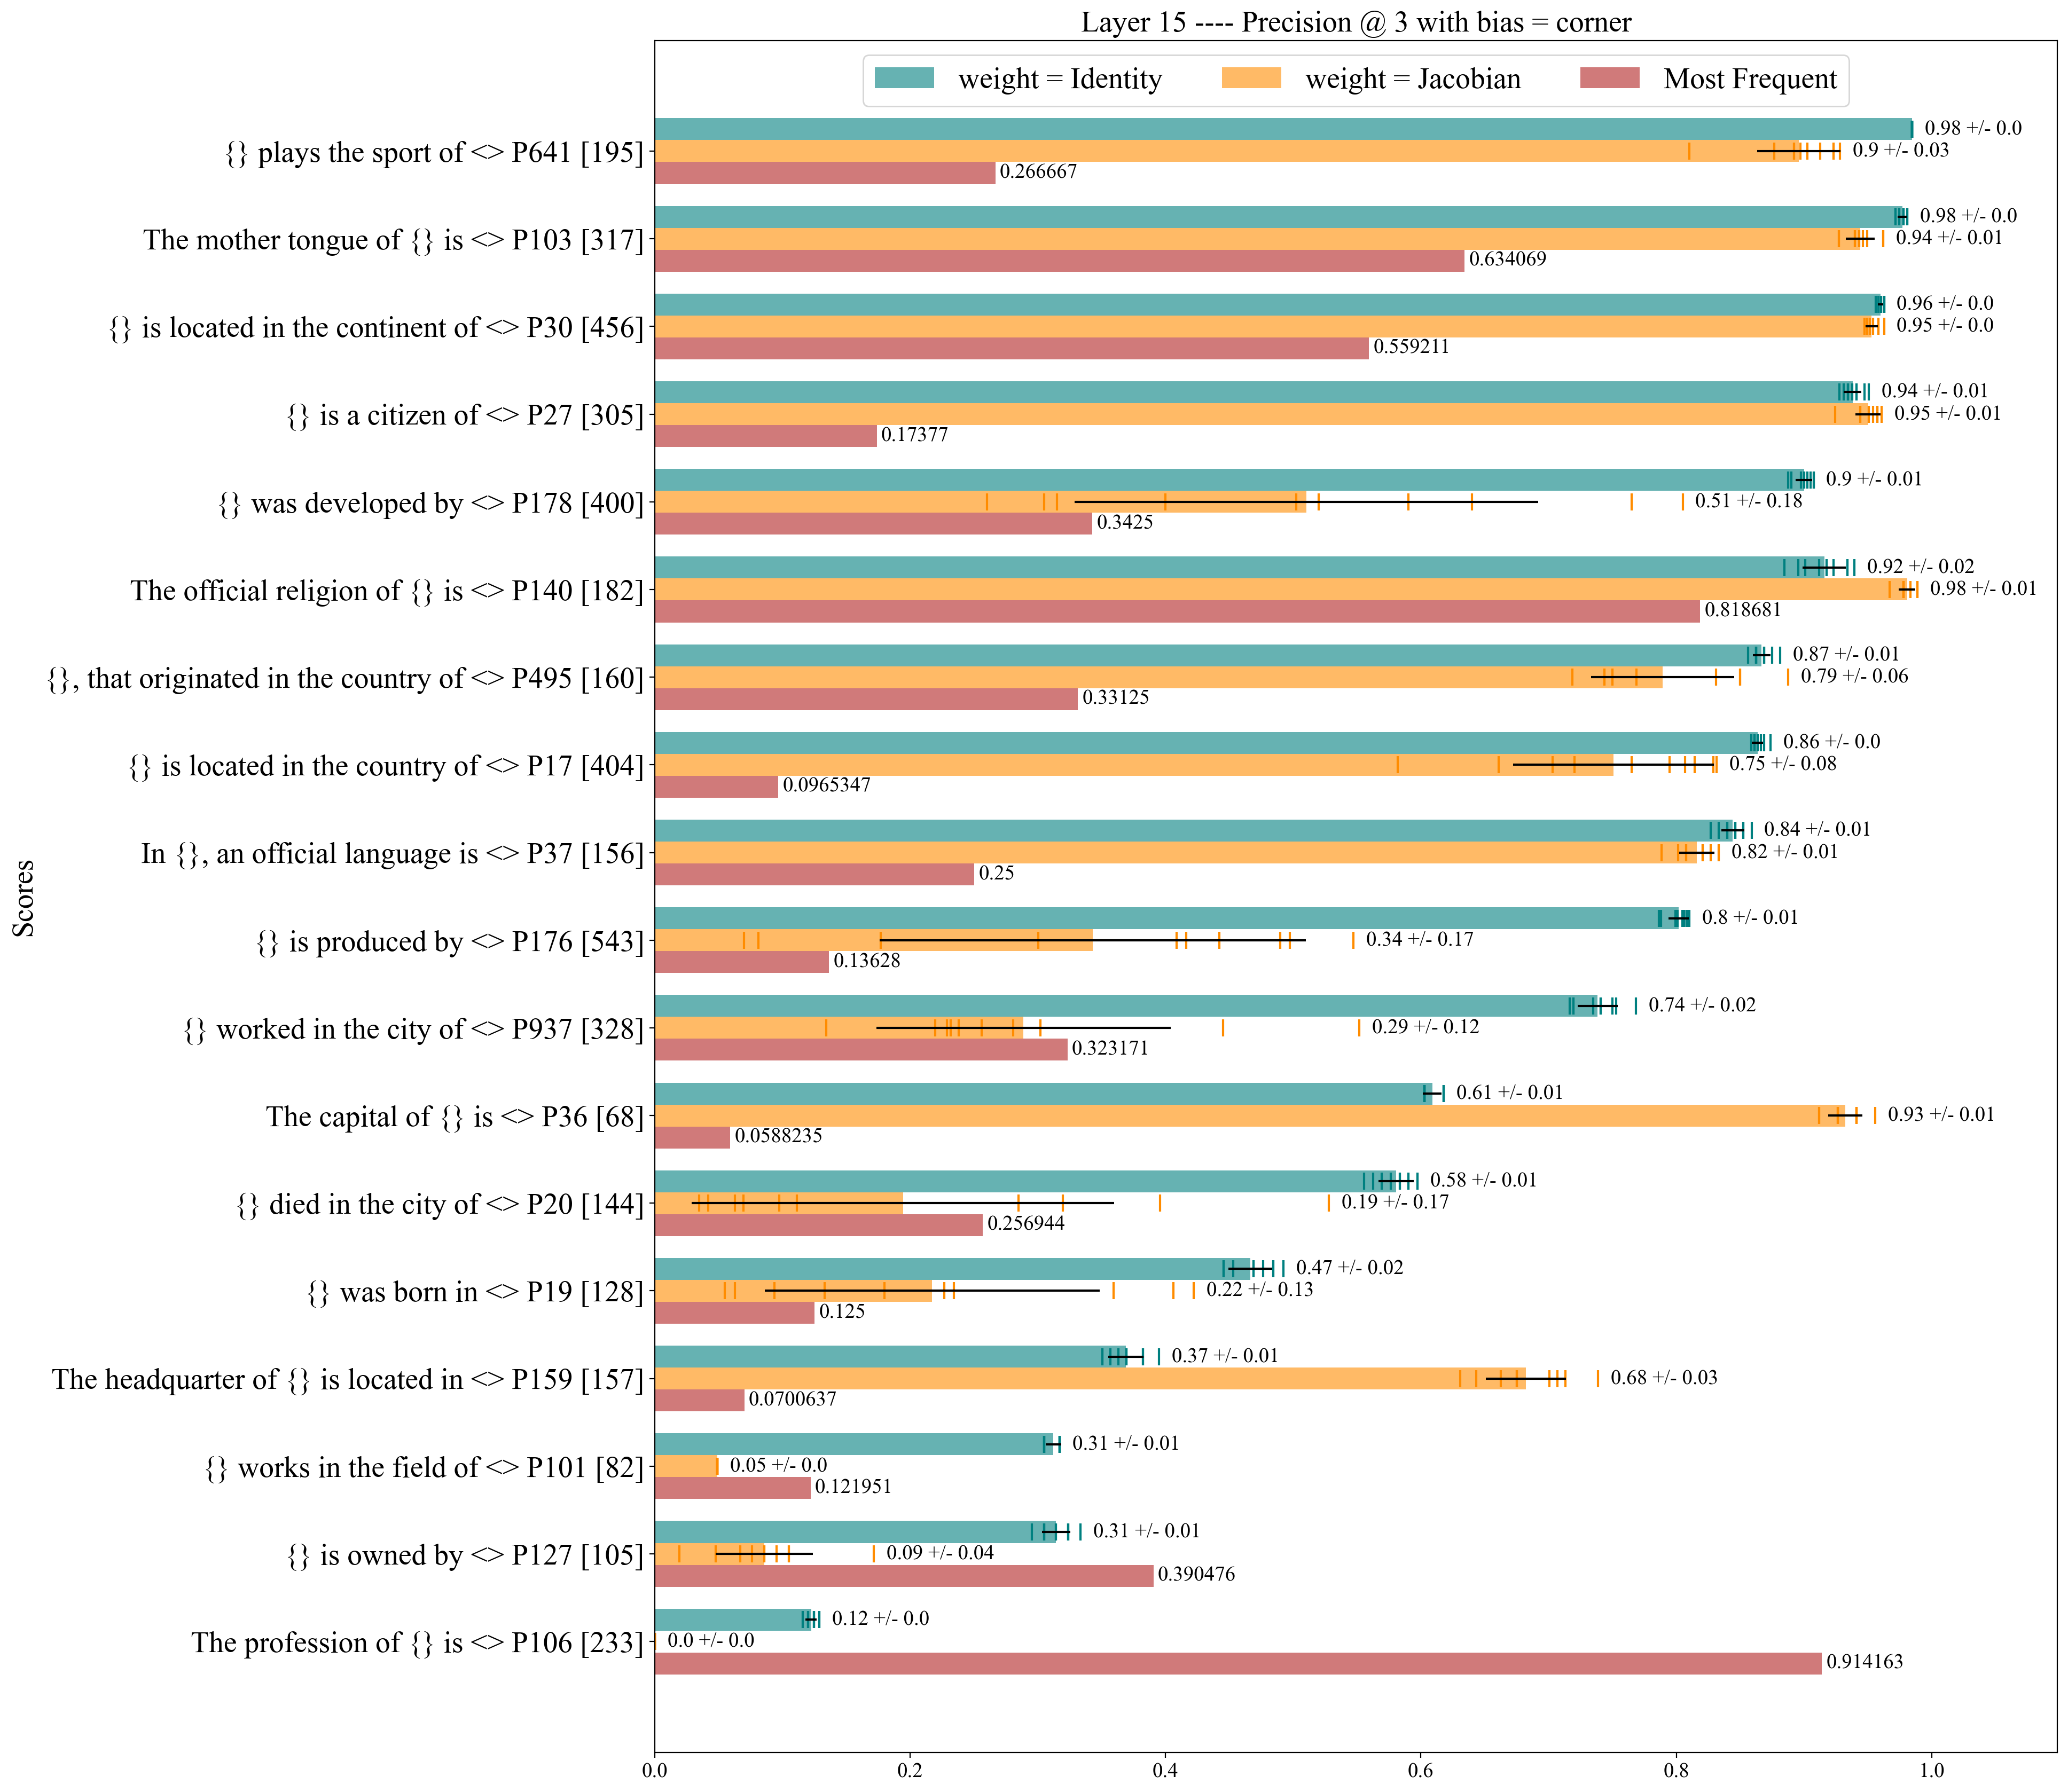

In [93]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20,17)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


identity_color = "teal"
jacobian_color = "darkorange"
frequency_color = "firebrick"
bar_alpha = 0.6

y = np.arange(len(relations))  # the label locations
width = 0.75  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(y + width/3, identity_accuracies.mean(axis = 1), width/3, label='weight = Identity', xerr = identity_accuracies.std(axis = 1), color = identity_color, alpha = bar_alpha)
rects2 = ax.barh(y, jacobian_accuracies.mean(axis = 1), width/3, label='weight = Jacobian', xerr = jacobian_accuracies.std(axis = 1), color = jacobian_color, alpha = bar_alpha)
rects3 = ax.barh(y - width/3, freq_accuracies, width/3, label='Most Frequent', color = frequency_color, alpha = bar_alpha)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title(f'Layer {layer} ---- Precision @ 3 with bias = corner')
ax.set_yticks(y, relations)
ax.legend(loc="upper center", ncol=3)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)
def add_bar_labels(rects, accuracies, color = "black"):
    labels = [f"{round(acc.mean(), 2)} +/- {round(acc.std(), 2)}" for acc in accuracies]
    for rect, acc, label in zip(rects, accuracies, labels):
        # x_pos = acc.mean() + acc.std() + .01
        x_pos = acc.max() + 0.01
        y_pos = rect.get_y() + rect.get_height() / 2
        ax.text(
            x_pos, y_pos, label, ha="left", va="center",
        )
        points = acc
        ax.scatter(points, [y_pos]*len(points), color = color, marker="|", s = 140)

add_bar_labels(rects1, identity_accuracies, color = identity_color)
add_bar_labels(rects2, jacobian_accuracies, color = jacobian_color)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.savefig(f"performance_conparison.png")

plot_margin = 0.06

x0, x1, y0, y1 = plt.axis()
plt.axis((x0, x1 + plot_margin, y0, y1))

fig.show()

array([0.41506801, 0.77076303, 0.17277559, 0.46119687, 0.6113492 ])